# Notebook to compute the LSST's passbands and the impact of the atmospheric parameters on the colors of reference sources 

In this notebook we are going to take the reference spectra from the pysynphot's spectral atlases and make them pass through the LSST's throughput and the simulated atmospheres from the previous notebooks. 

This notebook requires [pysynphot](https://pysynphot.readthedocs.io/en/latest/) 


# Load necessary packages 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pysynphot as S
from scipy.interpolate import interp1d
from scipy import integrate
from astropy.io import fits
#import quadpy

# allow interactive plots
#%matplotlib widget

In [2]:
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 45238.93416
   waveset: Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True


# Define LaTeX commands 

$\newcommand{\AA}{\mathit{\unicode{x212B}}}$
Angstrom symbol: $\AA$

# Set LSST's parameters 

In [3]:
WLMIN=3400. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=10600. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom
# from key numbers
Reff=642.3/2. # effective radius in cm
Seff= np.pi*Reff**2  # in cm2
print(Seff)
exptime=30.0

324015.4546769212


In [4]:
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m effective aperture 
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3400.0, Max: 10600.0, Num: None, Delta: 1.0, Log: False


# Set wavelength units 

In [5]:
waveunits = 'angstrom'
wavelabel = r'$\AA$'

# Define general paths 

In [6]:
outdir_plots0 = 'output_plots/'
if os.path.exists(outdir_plots0)==False:
    os.mkdir(outdir_plots0)
outdir_files = 'output_files/'
if os.path.exists(outdir_files)==False:
    os.mkdir(outdir_files)

# Define paths to spectral atlases 

In [7]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_dict = {
    'calspec':os.path.join(pysynphot_root_path,'calspec'),
    'bpgs':os.path.join(pysynphot_root_path,'grid/bpgs'),
    'jacoby':os.path.join(pysynphot_root_path,'grid/jacobi'),
    'pickles':os.path.join(pysynphot_root_path,'grid/pickles/dat_uvk')
}

atlas_dir = 'spectral_atlases/'
file_dict = {
    'calspec':'',
    'bpgs':os.path.join(atlas_dir,'atlas_bpgs.txt'),
    'jacoby':os.path.join(atlas_dir,'atlas_jacoby.txt'),
    'pickles':os.path.join(atlas_dir,'atlas_pickles.txt')
}


# Select a spectral atlas 

Options: 
* calspec (HST calibration spectra): work in progress, need to separate stars from AGNs and other sources 
* bpgs (Bruzual-Persson-Gunn-Stryker): 175 spectra 
* jacobi (Jacoby-Hunter-Christian): 161 spectra 
* pickles (Pickles): 131 spectra 

In [8]:
atlas_name = 'pickles'

atlas_path = path_dict[atlas_name]
atlas_file = file_dict[atlas_name]

# Find the spectra files and information 

In [9]:
#path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
atlas_seds = pd.read_csv(atlas_file)
atlas_seds

File Type      Teff     Name
0      pickles_uk_1.fits  O5V  39810.70  unknown
1      pickles_uk_2.fits  O9V  35481.40  unknown
2      pickles_uk_3.fits  B0V  28183.80  unknown
3      pickles_uk_4.fits  B1V  22387.20  unknown
4      pickles_uk_5.fits  B3V  19054.60  unknown
..                   ...  ...       ...      ...
126  pickles_uk_127.fits  G8I   4591.98  unknown
127  pickles_uk_128.fits  K2I   4255.98  unknown
128  pickles_uk_129.fits  K3I       NaN  unknown
129  pickles_uk_130.fits  K4I   3990.25  unknown
130  pickles_uk_131.fits  M2I   3451.44  unknown

[131 rows x 4 columns]

# Load with pysynphot the spectra from the selected atlas 

In [10]:
sed_list = np.array(atlas_seds['File'])

In [11]:
sed_dict = {}
type_dict = {}
for i,sed in enumerate(sed_list):
    #print('-------')
    #print(sed)
    spec_ = S.FileSpectrum(os.path.join(atlas_path,sed))
    assert str(spec_.waveunits)==waveunits
    sed_dict[sed[:-5]] = spec_
    type_dict[sed[:-5]] = atlas_seds['Type'][i]

# Define also the spectral types 

In [12]:
spectral_types = ['O','B','A','F','G','K','M']

<img align="center" src = Stellar_Classification_Chart.png width=750 style="padding: 10px"> 

https://upload.wikimedia.org/wikipedia/commons/3/37/Stellar_Classification_Chart.png

# Organise spectra by spectral type 

In [13]:
spec_by_type = {}
for i in range(len(spectral_types)):
    spec_type = spectral_types[i]
    
    type_list_ = []
    spec_by_type[spec_type] = []
    for sed_ in type_dict.keys():
        if spec_type in type_dict[sed_]:
            type_list_.append(type_dict[sed_])
            spec_by_type[spec_type].append(sed_dict[sed_])
    print(spec_type, type_list_)
    print(len(type_list_))
    print('-----------')

O ['O5V', 'O9V', 'O8III']
3
-----------
B ['B0V', 'B1V', 'B3V', 'B57V', 'B8V', 'B9V', 'B2IV', 'B6IV', 'B12III', 'B3III', 'B5III', 'B9III', 'B2II', 'B5II', 'B0I', 'B1I', 'B3I', 'B5I', 'B8I']
19
-----------
A ['A0V', 'A2V', 'A3V', 'A5V', 'A7V', 'A0IV', 'A47IV', 'A0III', 'A3III', 'A5III', 'A7III', 'A0I', 'A2I']
13
-----------
F ['F0V', 'F2V', 'F5V', 'wF5V', 'F6V', 'rF6V', 'F8V', 'wF8V', 'rF8V', 'F02IV', 'F5IV', 'F8IV', 'F0III', 'F2III', 'F5III', 'F0II', 'F2II', 'F0I', 'F5I', 'F8I']
20
-----------
G ['G0V', 'wG0V', 'rG0V', 'G2V', 'G5V', 'wG5V', 'rG5V', 'G8V', 'G0IV', 'G2IV', 'G5IV', 'G8IV', 'G0III', 'G5III', 'wG5III', 'rG5III', 'G8III', 'wG8III', 'G5II', 'G0I', 'G2I', 'G5I', 'G8I']
23
-----------
K ['K0V', 'rK0V', 'K2V', 'K3V', 'K4V', 'K5V', 'K7V', 'K0IV', 'K1IV', 'K3IV', 'K0III', 'wK0III', 'rK0III', 'K1III', 'wK1III', 'rK1III', 'K2III', 'wK2III', 'rK2III', 'K3III', 'wK3III', 'rK3III', 'K4III', 'wK4III', 'rK4III', 'K5III', 'rK5III', 'K01II', 'K34II', 'K2I', 'K3I', 'K4I']
32
-----------
M [

Now we can plot them by spectral type separately 

In [14]:
type_colors = {'O':'b','B':'dodgerblue','A':'cyan','F':'g','G':'gold','K':'r','M':'brown'}

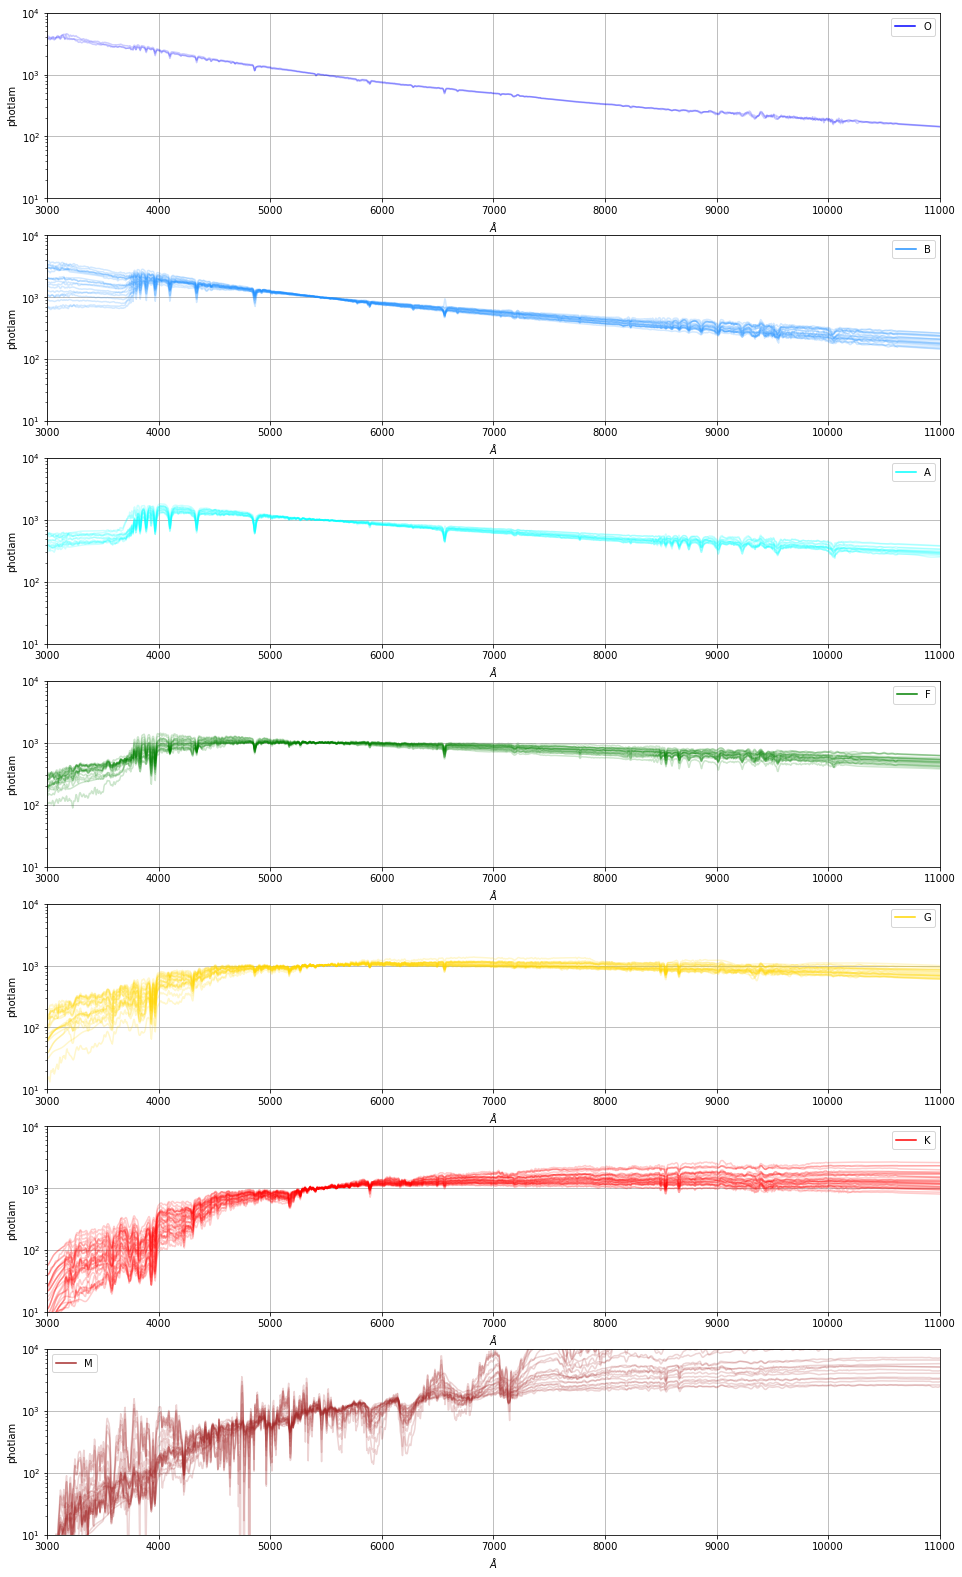

In [15]:
num_rows = len(spectral_types)
fig, axs = plt.subplots(num_rows, 1, figsize=(16,28))

for row,st in enumerate(spectral_types):
    for spec in spec_by_type[st]:
        spec.convert('photlam')
        axs[row].plot(spec.wave,spec.flux,color=type_colors[st],alpha=0.2)
    axs[row].plot([],[],label=st,color=type_colors[st])
    axs[row].grid()
    #axs[row].set_yscale("log")
    axs[row].set_xlabel(wavelabel)
    axs[row].set_ylabel(spec.fluxunits)
    axs[row].legend()
    axs[row].set_xlim(3000,11000)
    axs[row].set_ylim(10,10000)
    axs[row].set_yscale("log")
            

# Now we assign an ID to each object and we also classify these IDs by spectral type 

In [16]:
id_dict = {}
for i,sed in enumerate(sed_list):
    id_dict[sed[:-5]] = '{0}'.format(i+1).zfill(len(str(len(sed_list))))

In [17]:
id_by_type = {}
for i in range(len(spectral_types)):
    spec_type = spectral_types[i]
    
    id_list_ = []
    id_by_type[spec_type] = []
    for sed_ in id_dict.keys():
        if spec_type in type_dict[sed_]:
            id_list_.append(id_dict[sed_])
            id_by_type[spec_type].append(sed_)
    print(spec_type, id_list_)
    print(len(id_list_))
    print('-----------')

O ['001', '002', '060']
3
-----------
B ['003', '004', '005', '006', '007', '008', '046', '047', '061', '062', '063', '064', '106', '107', '114', '115', '116', '117', '118']
19
-----------
A ['009', '010', '011', '012', '013', '048', '049', '065', '066', '067', '068', '119', '120']
13
-----------
F ['014', '015', '016', '017', '018', '019', '020', '021', '022', '050', '051', '052', '069', '070', '071', '108', '109', '121', '122', '123']
20
-----------
G ['023', '024', '025', '026', '027', '028', '029', '030', '053', '054', '055', '056', '072', '073', '074', '075', '076', '077', '110', '124', '125', '126', '127']
23
-----------
K ['031', '032', '033', '034', '035', '036', '037', '057', '058', '059', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '111', '112', '128', '129', '130']
32
-----------
M ['038', '039', '040', '041', '042', '043', '044', '045', '095', '096', '097', '098', '099', '100', '101', '102', '103', '

# Load LSST's throughput 

https://github.com/lsst/throughputs/tree/main/baseline

In [18]:
throughput_path = 'data/lsst/'
throughput_label = 'hardware_{0}.dat'

In [19]:
filters = ['u','g','r','i','z','Y']
filter_names = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'Y'}
filter_colors = {0:'b',1:'g',2:'r',3:'orange',4:'k',5:'grey'}

Write the throughputs in pysynphot format 

In [20]:
lsst_bp = []
for i,f in enumerate(filters):
    throughput_ = np.loadtxt(throughput_path+throughput_label.format(f.lower()))
    wl = throughput_[:,0]*10.
    lsst_bp.append(S.ArrayBandpass(wl, throughput_[:,1] , name=f))
    assert str(lsst_bp[i].waveunits)==waveunits


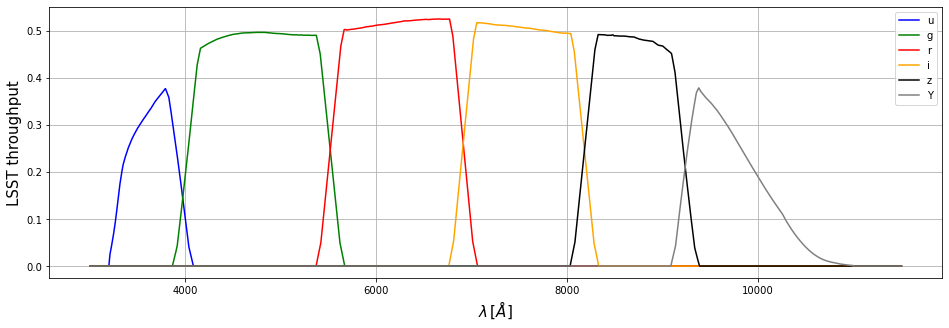

In [21]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for index in range(len(lsst_bp)):
    ax.plot(lsst_bp[index].wave,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
plt.xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()

In [22]:
for filter in lsst_bp:
    assert (filter.wave==lsst_bp[0].wave).all()

In [23]:
wl_lsst = lsst_bp[0].wave

For each filter we can define the effective wavelength, $\lambda_b^{eff}$, as 

$$\lambda_b^{eff} = \frac{\int \lambda \, T_{tel,b}(\lambda) \, d\lambda}{\int T_{tel,b}(\lambda) \, d\lambda} \, . $$

In [24]:
def calc_eff_lambda(T):
    assert (np.isnan(T.throughput)==True).any()==False
    
    wl_ = T.wave
    trans_ = T.throughput
    
    num_ = np.trapz(wl_*trans_,x=wl_)
    den_ = np.trapz(trans_,x=wl_)
    
    return num_/den_

In [25]:
eff_lambda = {}
for i,filter in enumerate(filters):
    eff_lambda[filter] = calc_eff_lambda(lsst_bp[i])
    print(calc_eff_lambda(lsst_bp[i]))

3646.6653725477827
4775.689949910929
6221.858748950202
7538.742212119657
8695.989905566856
9703.26518629804


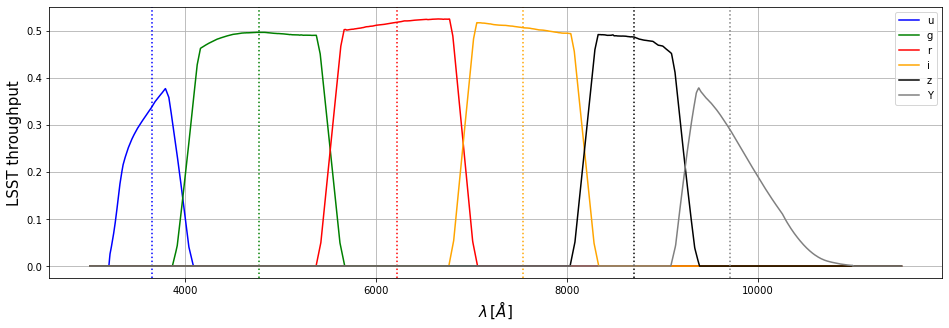

In [26]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for i,filter in enumerate(filters):
    ax.plot(lsst_bp[i].wave,lsst_bp[i].throughput,label=filter_names[i],color=filter_colors[i])
    ax.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
ax.grid()
plt.xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()

# Load simulated transparencies 

Select variable parameter and specify airmass and clouds 

In [27]:
variable_param = 'pwv'
am0 = 1.2
cloud0 = 0.0
pwv0 = 3.0
aero0 = 0.04

Specify which distribution follows the simulated parameter. Options: 
* linear_distribution-discrete: generated following a linear function and with pre-established step (e.g., PWV = 1.0, 2.0, 3.0, ....) 
* linear_distribution-continuous: generated following a linear function and specifying only the value range and number of simulations (e.g., PWV = 1.0, 1.25, 1.5, ....) 
* uniform_distribution: generated following a uniform random distribution (work in progress) 
* specific_distribution: generated following random distributions specific to each parameter (work in progress) 


In [28]:
param_dist = 'linear_distribution-discrete'

In [29]:
outdir_plots_ = os.path.join('output_plots/',param_dist.split('-')[0])
if os.path.exists(outdir_plots_)==False:
    os.mkdir(outdir_plots_)

outdir_plots = os.path.join('output_plots/',param_dist.replace('-','/'))
if os.path.exists(outdir_plots)==False:
    os.mkdir(outdir_plots)

In [30]:
if variable_param=='airmass' or variable_param=='cloud':
    t_file = 'simulated_transparencies_varying_{0}.fits'.format(variable_param)
    t_file_ref = 'simulated_transparencies_varying_{0}_ref.fits'.format(variable_param)
else:
    t_file = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}.fits'.format(variable_param,am0,cloud0)
    t_file_ref = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}_ref.fits'.format(variable_param,am0,cloud0)

t_path = os.path.join('./simulated_transparencies/',param_dist.replace('-','/'))
t_in = os.path.join(t_path,t_file)
t_in_ref = os.path.join(t_path,t_file_ref)
t = fits.open(t_in)
t_ref = fits.open(t_in_ref)

In [31]:
head = t[0].header
data = t[0].data
print(data.shape)
data_ref = t_ref[0].data
print(data_ref.shape)

(10, 956)
(2, 956)


In [32]:
n_atmp = head['ID_RES']
n_sim = head['NTRANSP']
print(n_atmp, n_sim)

5 9


In [33]:
wl_t = data[0][n_atmp:]*10.

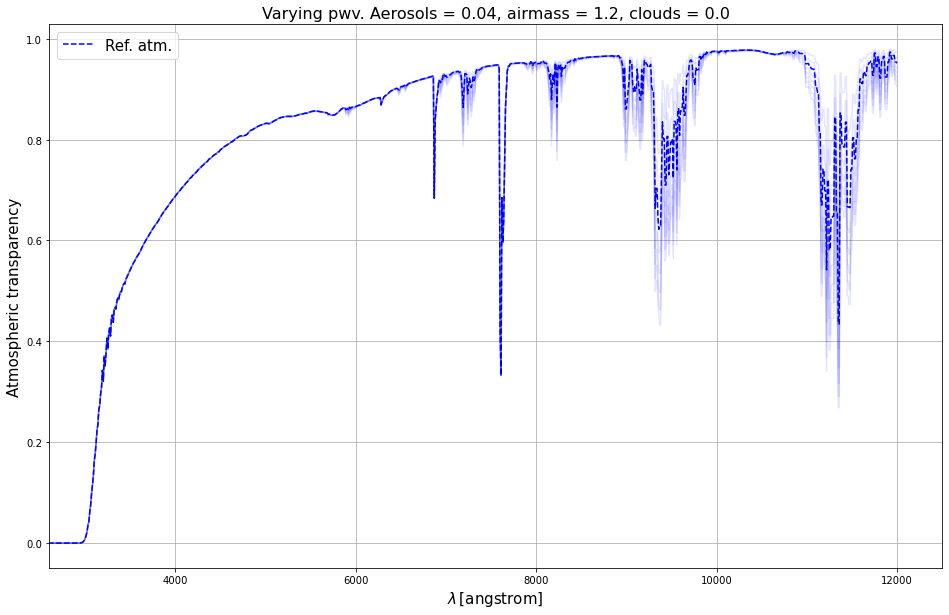

In [34]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for atm_i in range(1,n_sim):
    ax.plot(wl_t,data[atm_i][n_atmp:],color='b',alpha=0.1)
ax.plot(wl_t,data_ref[1][n_atmp:],ls='--',color='b',label='Ref. atm.')
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \,$'+'[angstrom]',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=16)
plt.legend(fontsize=15)
plt.savefig(os.path.join(outdir_plots,'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

# Check range of values of variable parameter 

In [35]:
print(head)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  956                                                  NAXIS2  =                   10                                                  NTRANSP =                    9                                                  ID_AM   =                    4                                                  ID_VAOD =                    1                                                  ID_PWV  =                    0                                                  ID_O3   =                    2                                                  ID_CLD  =                    3                                                  ID_RES  =                    5                                                  END                                     

In [36]:
params_index = {'pwv':0,'aerosol':1,'ozone':2,'cloud':3,'airmass':4}

In [37]:
var_index = params_index[variable_param]

In [38]:
#data[1:,1]
data[1:,var_index]

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

# Select data for variable parameter of these simulations 

In [39]:
atm_vals = data[1:,var_index]

In [40]:
np.save('output_files/atm_vals_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),atm_vals)

# Convert simulated transparencies into pysynphot format 

In [41]:
atm_transp = []
for i in range(1,n_sim+1):
    finterp_i = interp1d(wl_t,data[i][n_atmp:],bounds_error=False,fill_value=0.)
    atm_interp_i = finterp_i(wl_lsst)
    #atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
    atm_i = S.ArrayBandpass(wl_lsst,atm_interp_i, name='Atm. transp. {0}'.format(i))
    assert str(atm_i.waveunits)==waveunits
    atm_transp.append(atm_i)

In [42]:
finterp_ref = interp1d(wl_t,data_ref[1][n_atmp:],bounds_error=False,fill_value=0.)
atm_interp_ref = finterp_ref(wl_lsst)
#atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
atm_transp_ref = S.ArrayBandpass(wl_lsst,atm_interp_ref, name='Atm. transp. {0}'.format(i))
assert str(atm_transp_ref.waveunits)==waveunits

# Compute total bandpass (atmosphere(s) x LSST throughput) 

In [43]:
total_passband = {}
#for bpname in filters:
#    total_passband[bpname] = []

for index,bp in enumerate(lsst_bp):
    total_passband[filters[index]] = []
    for i in range(n_sim):
        total_pass = bp*atm_transp[i]
        total_passband[bp.name].append(total_pass)

In [44]:
total_passband_ref = {}
for index,bp in enumerate(lsst_bp):
    total_pass = bp*atm_transp_ref
    total_passband_ref[bp.name] = total_pass

In [45]:
print(len(total_passband['u']))
print(total_passband['u'][0])

9
(u * Atm. transp. 1)


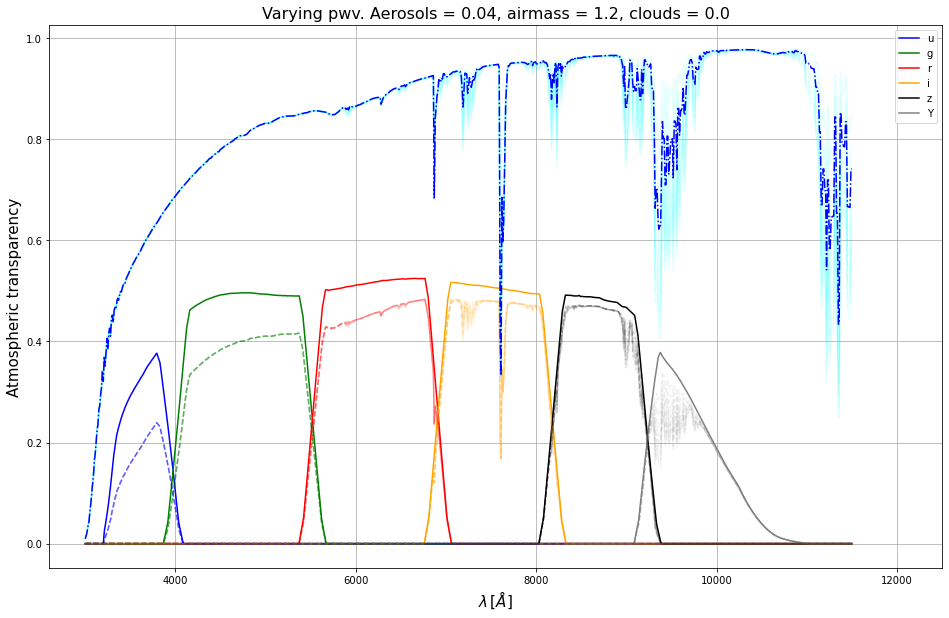

In [46]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for index,bp in enumerate(lsst_bp):
    ax.plot(bp.wave,bp.throughput,label=filter_names[index],color=filter_colors[index])

for isim in range(n_sim):
    ax.plot(atm_transp[isim].wave,atm_transp[isim].throughput,alpha=0.1,color='cyan')
    for index,bpname in enumerate(filters):
        ax.plot(total_passband[bpname][isim].wave,total_passband[bpname][isim].throughput,ls='--',color=filter_colors[index],alpha=0.1)
ax.plot(atm_transp_ref.wave,atm_transp_ref.throughput,ls='-.',color='b')        
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.legend()
plt.title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'total_passbands_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

Plot the atmospheric transparencies corresponding to the minimum and maximum atmospheric parameter that we are varying: 

In [47]:
min_val_ = np.min(atm_vals)
max_val_ = np.max(atm_vals)
print(min_val_,max_val_)

1.0 9.0


In [48]:
min_ind_ = np.where(atm_vals==min_val_)[0][0]
max_ind_ = np.where(atm_vals==max_val_)[0][0]

In [49]:
min_transp = data[1+min_ind_,n_atmp:]
max_transp = data[1+max_ind_,n_atmp:]

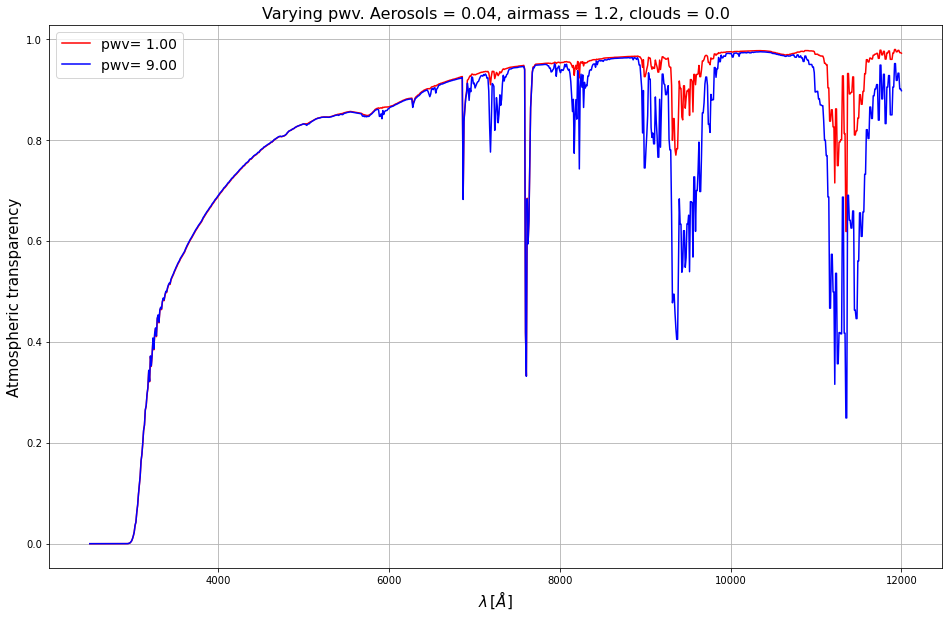

In [50]:
fig=plt.figure(figsize=(16,10))
plt.plot(wl_t,min_transp,color='r',label=variable_param+'= {0:.2f}'.format(min_val_))
plt.plot(wl_t,max_transp,color='b',label=variable_param+'= {0:.2f}'.format(max_val_))
plt.xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.grid()
plt.legend(fontsize=14)
plt.title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}_min_max_values.png'.format(variable_param,am0,cloud0)))

# Calculate fluxes through total passbands 

Let's start with one spectrum of a type A star as example 

In [51]:
# Example with one spectrum 
test_type = 'A'
test_spec = 0
example_spec = spec_by_type[test_type][test_spec]
example_id = id_by_type[test_type][test_spec]
print(example_spec,example_id)

/home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/grid/pickles/dat_uvk/pickles_uk_9.fits pickles_uk_9


In [52]:
obs_flux_t_dict = {}
obs_flux_std_dict = {}

for ised in sed_dict.keys():
    #print(ised)
    sed_ = sed_dict[ised]
    
    obstotal_dict_ = {}
    for filter in filters:
        obstotal_dict_[filter] = []

    for filter in filters:
        #print(filter.name.upper())
        for i in range(n_sim):
            #total_pass = filter*atm_transp[i]
            #obs = S.Observation(spec,total_pass,force='taper')
            obstotal_ = S.Observation(sed_,total_passband[filter][i],force='taper')
            obstotal_dict_[filter].append(obstotal_)
    
    obs_flux_t_dict[ised] = obstotal_dict_

    obstotal_dict_ref_ = {}
    for filter in filters:
        obstotal_dict_ref_[filter] = S.Observation(example_spec,total_passband_ref[filter],force='taper')
        
    obs_flux_std_dict[ised] = obstotal_dict_ref_
    

# Calculate magnitudes with our own function 

Physical constants 

In [53]:
c_light = S.units.C #speed of light [Angstrom /s] 
print(c_light)
h_planck = S.units.H #Planck's constant [erg*s] 
print(h_planck)

2.99792458e+18
6.6262e-27


In [54]:
# Reference flux value for an AB source in erg / s / cm2 / Hz 
f_ref = 3.63*10**(-20)

In [55]:
# Pivot wavelength [cm] 
wl_piv = 5.4929*10**(-5)

In [56]:
C = f_ref/(h_planck*wl_piv*10**8.)
print(C)

997.3334660532323


Definition of functions 

In [57]:
# The SED of an AB source (that is, constant flux in frequency units) expressed in photons / s / cm^2 / Angstrom 
def ABnphot(wl):
    #return 997.2*5500./wl
    return C*wl_piv*10**8./wl

We check that this function actually creates a spectrum with the properties of an AB source, that is, a flat spectrum in fnu units (erg/s/cm2/Hz) 

Text(0, 0.5, 'Flux [Jy]')

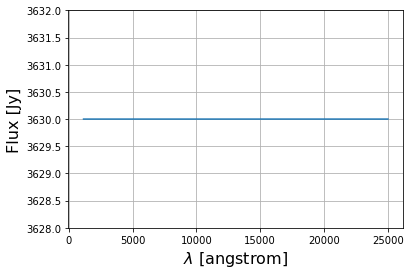

In [58]:
checkab = ABnphot(example_spec.wave)
checkab_ = S.ArraySpectrum(example_spec.wave, checkab, name='Flat AB spectrum')
#plt.plot(checkab_.wave,checkab_.flux)
checkab_.convert('fnu')
plt.plot(checkab_.wave,checkab_.flux*10**23.)
plt.ylim(3.628*10.**3,3.632*10**3.)
plt.grid()
plt.xlabel(r'$\lambda$ [angstrom]',fontsize=16)
plt.ylabel('Flux [Jy]',fontsize=16)

Now, we define our function to compute the AB magnitudes: 

$$m_{AB} = -2.5 \log_{10} \frac{\int F_{\nu}^E(\lambda) \cdot S_{eff} \cdot t_{exp} \cdot S_{passband}(\lambda) \frac{d\lambda}{h \lambda}}{\int F_{\nu, AB}^E \cdot S_{eff} \cdot t_{exp} \cdot S_{throughput}(\lambda) \frac{d\lambda}{h \lambda}} = -2.5 \log_{10} \frac{\varphi}{\Phi_{AB}} \, . $$ 

Now, we want to compute the error for the AB magnitudes. The denominator is constant for a given $S_{throughput}(\lambda)$, so we assume it does not contribute to the error. Then, we can approximate $\varphi$ as 

$$\varphi \approx \sum_i F_{\nu}^E(\lambda_i) \cdot S_{eff} \cdot t_{exp} \cdot S_{passband}(\lambda_i) \frac{\Delta \lambda_i}{h \lambda_i} = \sum_i n_i \cdot S_{passband}(\lambda_i) \cdot \Delta \lambda_i \, , $$ 

where $n_i$ is 

$$n_i = \frac{F_{\nu}^E(\lambda_i) \cdot S_{eff} \cdot t_{exp}}{h \lambda_i} \, ,$$

the number of photo-electrons received within a given bin of wavelength, $\Delta \lambda_i$. Then, we can assume that $n_i$ is a Poisson random variable, so 

$$\sigma^2_{n_i} = n_i . $$ 

Taking this into account, we can write the error of $\varphi$ as 

$$\sigma^2_{\varphi} = \sum_i \left( \frac{\partial \varphi}{\partial n_i} \right)^2 \sigma^2_{n_i} = \sum_i n_i \cdot \left( S_{passband}(\lambda_i) \cdot \Delta \lambda_i \right)^2 \, , $$ 

Finally, the error on $m_{AB}$ is given by 
$$\sigma^2_{m_{AB}} = \left( \frac{\partial m_{AB}}{\partial \varphi} \right)^2 \sigma^2_{\varphi} = \left( \frac{-2.5}{\varphi \log 10} \right)^2 \cdot \sum_i n_i \cdot \left( S_{passband}(\lambda_i) \cdot \Delta \lambda_i \right)^2 \, . $$ 


In [59]:
def int_flux(spec,passband,filter=None,return_mag=False,return_error=False,
             PhiAB=None,renormalize=None,verbose=False):
    f_units = str(spec.fluxunits)
    if f_units!='fnu':
        if verbose:
            print('ATTENTION: converting flux units to fnu')
        spec.convert('fnu')
        
    observation = S.Observation(spec,passband,force='taper')
    if verbose:
        print('Observation units = ', observation.fluxunits)
    nan_mask = np.isnan(observation.flux)
    
    obs_wave_ = observation.wave[~nan_mask]
    obs_flux_ = observation.flux[~nan_mask]
    wave_min = np.min(observation.wave[~nan_mask])
    wave_max = np.max(observation.wave[~nan_mask])
    
    if renormalize!=None:
        renorm = np.power(10.,-1.*renormalize/2.5)
    else:
        renorm = 1.0
    
    num = np.trapz(obs_flux_*renorm/obs_wave_,x=obs_wave_)*Seff*exptime/h_planck
    
    if return_error:
        finterp_pb = interp1d(passband.wave,passband.throughput,bounds_error=False,fill_value=0.)
        pb_interp = finterp_pb(spec.wave)
        
        delta_lambda = list(np.diff(spec.wave))
        delta_lambda.append(spec.wave[-1]-spec.wave[-2])
        delta_lambda = np.array(delta_lambda)
        assert len(delta_lambda)==len(spec.wave)
        
        assert str(spec.fluxunits)=='fnu'
        n_i = spec.flux*renorm*Seff*exptime/(spec.wave*h_planck)
        print('n_i = ', n_i)
        #print('Number of collected photoelectrons = {0:.2e}'.format(np.sum(n_i*pb_interp)))
        err2_num = np.sum(n_i*(np.array(pb_interp)*delta_lambda)**2.)
    
    spec.convert(f_units)
    
    if verbose:
        print('Numerator = {0:.2e}'.format(num))
    if return_error and verbose:
        print('Variance of the numerator = {0:.2e}'.format(err2_num))
    
    if return_mag:
        
        if PhiAB is None:
            assert filter is not None
            flatsp_nphot = ABnphot(spec.wave)
            flatsp_ = S.ArraySpectrum(spec.wave, flatsp_nphot, name='Flat AB spectrum')

            flatsp_.convert('fnu')
            ab_obs = S.Observation(flatsp_,filter,force='taper')
            if verbose:
                print('AB observation units = ', ab_obs.fluxunits)

            ab_wave_ = ab_obs.wave[~nan_mask]
            ab_flux_ = ab_obs.flux[~nan_mask]

            den = np.trapz(ab_flux_/ab_wave_,x=ab_wave_)*Seff*exptime/h_planck
        else:
            den = PhiAB
            if verbose:
                print('ATTENTION: using external Phi_AB. Not computing it')

        if verbose:
            print('Denominator = {0:.2e}'.format(den))
        mab = -2.5*np.log10(num/den)
        if verbose:
            print('AB magnitude = ', mab)
            print('---------')
    
    if return_mag==False:
        if return_error:
            return num,np.sqrt(err2_num)
        else:
            return num
    else:
        if return_error:
            err2_mab = (2.5**2./np.log(10.)**2.)*err2_num/num**2.
            err_mab = np.sqrt(err2_mab)
            return num,mab,np.sqrt(err2_num),err_mab
        else:
            return num,mab
    

To avoid computing $\Phi_{AB}$ each time, we define that integral once and we give it to our function each time it is needed 

In [60]:
flatsp_nphot = ABnphot(example_spec.wave)

In [61]:
flat_spec = S.ArraySpectrum(example_spec.wave, flatsp_nphot, name='Flat AB spectrum')

In [62]:
Phi_AB = []
for filter in lsst_bp:
    Phi_AB_b = int_flux(flat_spec,filter)
    Phi_AB.append(Phi_AB_b)
    print(Phi_AB_b)
Phi_AB = np.array(Phi_AB)

3088398409927.2
8219719263298.365
6160614701335.237
4552583446697.673
3081715818183.534
1647819206182.2043


In [63]:
for filter in lsst_bp:
    nn,mm = int_flux(flat_spec,filter,filter=filter,return_mag=True,verbose=True)
    print(nn,mm)

ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 3.09e+12
AB observation units =  fnu
Denominator = 3.09e+12
AB magnitude =  -0.0
---------
3088398409927.2 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 8.22e+12
AB observation units =  fnu
Denominator = 8.22e+12
AB magnitude =  -0.0
---------
8219719263298.365 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 6.16e+12
AB observation units =  fnu
Denominator = 6.16e+12
AB magnitude =  -0.0
---------
6160614701335.237 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 4.55e+12
AB observation units =  fnu
Denominator = 4.55e+12
AB magnitude =  -0.0
---------
4552583446697.673 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 3.08e+12
AB observation units =  fnu
Denominator = 3.08e+12
AB magnitude =  -0.0
---------
3081715818183.534 -0.0
ATTENTION: converting flux units to fnu
Observa

In [64]:
for i,filter in enumerate(lsst_bp):
    nn,mm = int_flux(flat_spec,filter,return_mag=True,verbose=True,PhiAB=Phi_AB[i])
    print(nn,mm)

ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 3.09e+12
ATTENTION: using external Phi_AB. Not computing it
Denominator = 3.09e+12
AB magnitude =  -0.0
---------
3088398409927.2 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 8.22e+12
ATTENTION: using external Phi_AB. Not computing it
Denominator = 8.22e+12
AB magnitude =  -0.0
---------
8219719263298.365 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 6.16e+12
ATTENTION: using external Phi_AB. Not computing it
Denominator = 6.16e+12
AB magnitude =  -0.0
---------
6160614701335.237 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 4.55e+12
ATTENTION: using external Phi_AB. Not computing it
Denominator = 4.55e+12
AB magnitude =  -0.0
---------
4552583446697.673 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 3.08e+12
ATTENTION: using external Phi_AB. Not computing it
Denominat

NOTE: we store the integrated fluxes, $\vec{\varphi}_i(t)$ and magnitudes, $\vec{m}_i(t)$, through the standard atmosphere separately for checking purposes. In general, we will only have the integrated fluxes through the current atmosphere 

In [65]:
Phi_AB

array([3.08839841e+12, 8.21971926e+12, 6.16061470e+12, 4.55258345e+12,
       3.08171582e+12, 1.64781921e+12])

In [66]:
phi_t_dict = {}
phi_std_dict = {}
mag_t_dict = {}
mag_std_dict = {}

for ised in sed_dict.keys():
    sed_ = sed_dict[ised]
    
    phi_dict_std_ = {}
    mag_dict_std_ = {}
    for index,filter in enumerate(filters):
        num_,mag_ = int_flux(sed_,total_passband_ref[filter],
                        return_mag=True,PhiAB=Phi_AB[index])
        phi_dict_std_[filter] = num_
        mag_dict_std_[filter] = mag_
    phi_std_dict[ised] = phi_dict_std_
    mag_std_dict[ised] = mag_dict_std_
        
    phi_dict_t_ = {}
    mag_dict_t_ = {}
    
    for index,filter in enumerate(filters):
        phi_dict_t_[filter] = []
        mag_dict_t_[filter] = []
        for i in range(n_sim):
            num_,mag_ = int_flux(sed_,total_passband[filter][i],
                           return_mag=True,PhiAB=Phi_AB[index])
            phi_dict_t_[filter].append(num_)
            mag_dict_t_[filter].append(mag_)
        
        phi_t_dict[ised] = phi_dict_t_
        mag_t_dict[ised] = mag_dict_t_
    #print('###########################################################')
    

In [67]:
phi_t_dict[example_id]

{'u': [958748322846.175,
  958757577347.8854,
  958768415860.6895,
  958781510539.1764,
  958798111216.946,
  958955413388.1908,
  959512761986.7697,
  961115977977.8749,
  961210786202.0416],
 'g': [7100271394924.709,
  7100134789003.593,
  7100000386054.483,
  7099868852101.805,
  7099742539220.107,
  7099826387998.845,
  7100509473038.341,
  7102759250982.662,
  7102748753066.621],
 'r': [4776857717098.975,
  4775440861759.682,
  4774026485465.992,
  4772612678209.805,
  4771195687190.904,
  4769305809742.265,
  4766363808357.624,
  4760449477174.339,
  4758831339694.173],
 'i': [3110257477936.8945,
  3102237173796.2637,
  3094515374100.828,
  3087059993298.6133,
  3079841568430.322,
  3072384083844.1377,
  3064235290701.413,
  3053606671105.5996,
  3046980569261.29],
 'z': [1915401911737.891,
  1903465620092.3381,
  1892598023062.2332,
  1882575171023.4,
  1873259418280.7905,
  1864271042828.5635,
  1855258268200.008,
  1845009643837.4785,
  1837603852684.8147],
 'Y': [934858608117

In [68]:
mag_t_dict[example_id]

{'u': [1.2700717573625688,
  1.2700612771366013,
  1.27004900323179,
  1.2700341745524135,
  1.2700153758994928,
  1.2698372626429149,
  1.2692064118663005,
  1.267393807468939,
  1.26728671150223],
 'g': [0.15895508931776064,
  0.15897597857859216,
  0.1589965313615171,
  0.15901664579668365,
  0.15903596216598564,
  0.1590231395718256,
  0.15891868427356518,
  0.15857472607144876,
  0.15857633079653383],
 'r': [0.2762043556448785,
  0.2765264417139764,
  0.2768480595602084,
  0.2771696432525419,
  0.27749204672156363,
  0.2779221935846068,
  0.27859214916130615,
  0.27994021889356796,
  0.28030933721189727],
 'i': [0.41365393007128715,
  0.4164572932625877,
  0.419163175664647,
  0.4217821134922714,
  0.4243238465560052,
  0.4269560208080396,
  0.4298395123203531,
  0.43361204805565706,
  0.4359705755922154],
 'z': [0.5163316775476832,
  0.5231188761531557,
  0.5293355136489002,
  0.5351006525405594,
  0.5404866569177438,
  0.5457088342703478,
  0.550970529529527,
  0.556984867538215

u
g
r
i
z
Y
photlam


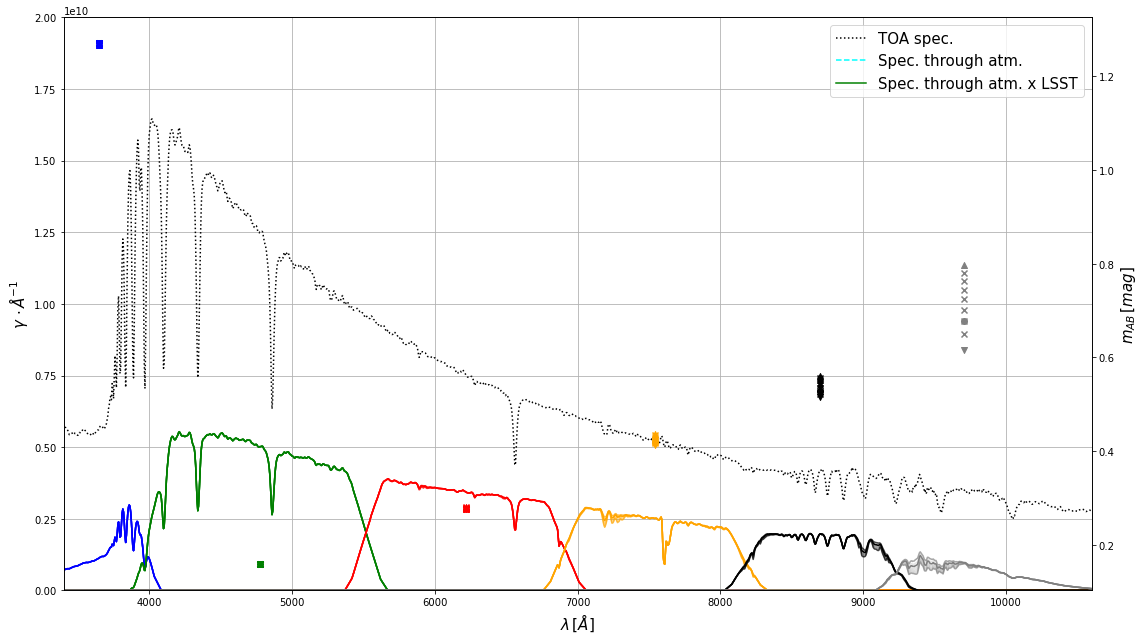

In [69]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls=':',color='k',alpha=1.0)

ax2 = ax1.twinx()

for index,filter in enumerate(filters):
    print(filter)
    obs = obs_flux_std_dict[example_id][filter]
    ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
    for i in range(n_sim):
        obs = obs_flux_t_dict[example_id][filter][i]
        if i==min_ind_ or i==max_ind_:
            alpha = 0.7
        else:
            alpha = 0.2
        ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=alpha)
        

ax1.set_xlim(WLMIN,WLMAX)
ax1.set_ylim(0.,2e10)
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()
ax1.plot([],[],ls=':',color='k',label='TOA spec.')
ax1.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
ax1.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')

for index,filter in enumerate(filters):
    ax2.scatter(eff_lambda[filter],mag_std_dict[example_id][filter],marker='o',color=filter_colors[index])
    for i in range(n_sim):
        if i==min_ind_:
            marker = 'v'
        elif i==max_ind_:
            marker = '^'
        else:
            marker = 'x'
        ax2.scatter(eff_lambda[filter],mag_t_dict[example_id][filter][i],marker=marker,color=filter_colors[index])

ax2.set_ylabel(r'$m_{AB} \, [mag]$',fontsize=15)
ax1.legend(fontsize=15)
plt.tight_layout()
print(spec.fluxunits)

u
g
r
i
z
Y
photlam


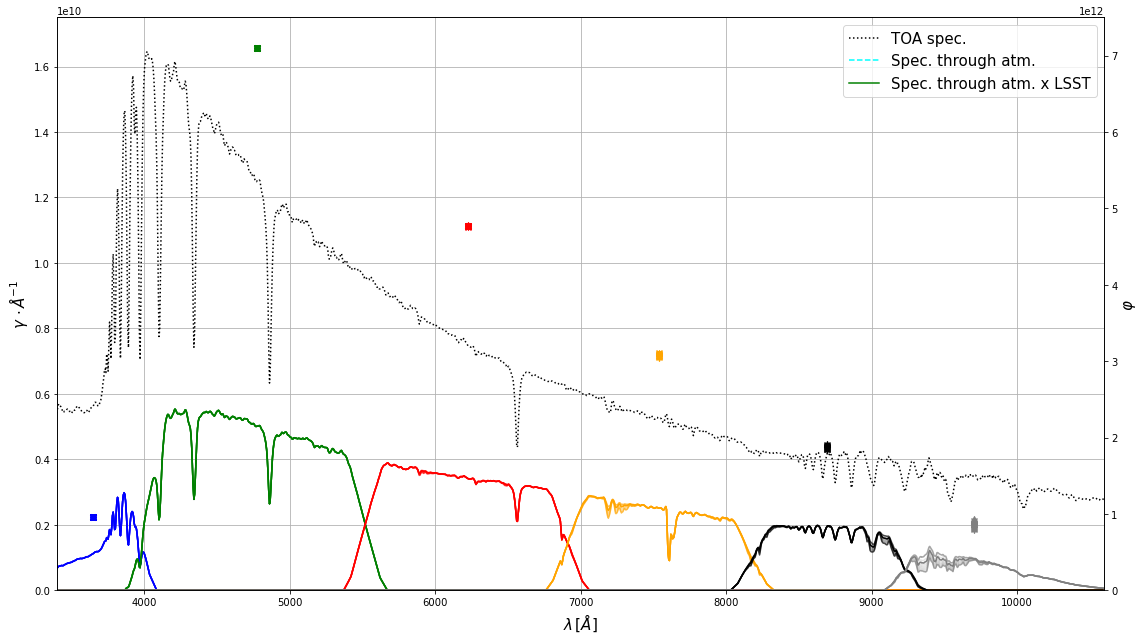

In [70]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls=':',color='k',alpha=1.0)

ax2 = ax1.twinx()

for index,filter in enumerate(filters):
    print(filter)
    obs = obs_flux_std_dict[example_id][filter]
    ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
    for i in range(n_sim):
        obs = obs_flux_t_dict[example_id][filter][i]
        if i==min_ind_ or i==max_ind_:
            alpha = 0.7
        else:
            alpha = 0.2
        ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=alpha)
        

ax1.set_xlim(WLMIN,WLMAX)
ax1.set_ylim(0.,1.75e10)
ax2.set_ylim(0,7.5e12)
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()
ax1.plot([],[],ls=':',color='k',label='TOA spec.')
ax1.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
ax1.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')

for index,filter in enumerate(filters):
    ax2.scatter(eff_lambda[filter],phi_std_dict[example_id][filter],marker='o',color=filter_colors[index])
    for i in range(n_sim):
        if i==min_ind_:
            marker = '^'
        elif i==max_ind_:
            marker = 'v'
        else:
            marker = 'x'
        ax2.scatter(eff_lambda[filter],phi_t_dict[example_id][filter][i],marker=marker,color=filter_colors[index])

ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=15)
plt.tight_layout()
print(spec.fluxunits)

### We store the observed integrated flux, $\vec{\varphi}_i(t)$ 

We store it for 2 cases: 
- Variable / current total passband 
- Standard total passband 

In [71]:
wl_eff = []
for filter in filters:
    print(filter)
    wl_eff.append(eff_lambda[filter])
wl_eff = np.array(wl_eff)

u
g
r
i
z
Y


# Polynomial fit of the integrated fluxes 

We have 6 bands, *ugrizY*, so we have 6 integrated fluxes, $\varphi_b$. Then, we consider the observed vector $\vec{\varphi}$. We can think of these integrated fluxes as the signal of very low resolution spectra, i.e. with very wide wavelength bins. Considering this, we associate each $\varphi_b$ with the effective wavelength, $\lambda_b^{eff}$, defined as before. 

Now, let us suppose that for a given source at a given moment we have integrated flux measurements in $N_{obs}$ bands, with $N_{obs} \leq 6$. Then, let us consider that TOA SED of the source can be described by a function $\hat{F}(\lambda)$. We consider this function to be a polynomial of order $n = N_{obs}-1$, i.e., 

$$\hat{F}(\lambda) = \sum_{i=0}^n a_i \lambda^i \, . $$ 

For a given band, $b$, the function $\hat{F}(\lambda)$ should meet 

$$\int \hat{F}(\lambda) \cdot T_b(\lambda) \cdot S_{eff} \cdot t_{exp} \frac{d\lambda}{h \lambda} = \varphi_b \, , $$ 

where $\hat{F}(\lambda)$ is *fnu* units, i.e., $erg \, s^{-1} cm^{-2} Hz^{-1}$ (note the counter-intuitive notation). If we expand $\hat{F}(\lambda)$ in its polynomial form, we can rewrite this expression as 

$$ \sum_{i=0}^n a_i \phi_b^i = \varphi_b \, , $$ 

where 

$$ \phi_b^i(t) = \int \lambda^{i-1} \cdot T_b(\lambda,t) \cdot S_{eff} \cdot t_{exp} \frac{d\lambda}{h} \, . $$ 

For $N \geq 2$ we will have a system of linear equations on the coefficients $a_i$: 

$$\begin{cases} 
\sum_{i=0}^n a_i \phi_{b_1}^i = \varphi_{b_1} \, \\ \qquad \vdots \\ \sum_{i=0}^n a_i \phi_{b_N}^i = \varphi_{b_N} \, . 
\end{cases}$$ 

If we express this in matrix notation, we have 

$$\begin{bmatrix} \phi_{b_1}^0 & \cdots & \phi_{b_1}^n \\ \vdots & \ddots & \vdots \\ \phi_{b_N}^0 & \cdots & \phi_{b_N}^n \end{bmatrix} \, \begin{bmatrix} a_0 \\ \vdots \\ a_n \end{bmatrix} = \begin{bmatrix} \varphi_{b_1} \\ \vdots \\ \varphi_{b_N} \end{bmatrix} \, . $$ 

In addition, we need to impose that $\hat{F}(\lambda)$ tends to 0 at least when for the wavelengths close to the bluest and reddest filters. To do this, let us consider two delta filters centered at two given wavelength, $\lambda_b$ and $\lambda_r$, which are smaller than the smallest wavelength of the bluer filter and bigger than the biggest wavelength of the redder one, respetively. We can write this as 

$$T_{\delta_b}(\lambda) = \delta(\lambda - \lambda_b) \, ,$$ 

and 

$$T_{\delta_r}(\lambda) = \delta(\lambda - \lambda_r) \, .$$ 

Following the same logic as before, the function $\hat{F}(\lambda)$ will have to meet the condition 

$$\sum_{i=0}^n a_i \phi^i_{\delta} = 0 \, $$

where $\phi^i_{\delta}$ are given by 

$$\phi_{\delta}^i = \int \lambda^{i-1} \cdot \delta(\lambda-\lambda_{\delta}) \cdot S_{eff} \cdot t_{exp} \frac{d\lambda}{h} \, = \lambda_{\delta}^{i-1} \cdot S_{eff} \cdot t_{exp}/h \, , $$ 

where the subscript $\delta$ corresponds to both $b$ and $r$, respectively. 

If we account for the two artificial delta passbands, we will have for a given object at a given moment $N_{obs} + 2$ integrated fluxes and therefore the order of the polynomial $\hat{F}(\lambda)$ will be $n = N_{obs}+1$. We can then add these two conditions to the previous matrix, so we have 

$$\begin{bmatrix} \phi_{\delta_b}^0 & \cdots & \phi_{\delta_b}^n \\ \phi_{b_1}^0 & \cdots & \phi_{b_1}^n \\ \vdots & \ddots & \vdots \\ \phi_{b_N}^0 & \cdots & \phi_{b_N}^n \\ \phi_{\delta_r}^0 & \cdots & \phi_{\delta_r}^n \end{bmatrix} \, \begin{bmatrix} a_0 \\ \vdots \\ a_n \end{bmatrix} = \begin{bmatrix} \varphi_{\delta_b} \\ \varphi_{b_1} \\ \vdots \\ \varphi_{b_N} \\ \varphi_{\delta_r} \end{bmatrix} \, , $$ 

or in vector notation, 

$$ M_{\phi} \vec{a} = \vec{\varphi} \, , $$ 

We note that for this matrix product $N \times n \cdot n = N $, where $N = N_{obs}+2$. Then, we can find the coefficients by solving 

$$ \vec{a} = M_{\phi}^{-1} \vec{\varphi} \, . $$ 

Note that the matrix $M_{\phi}$ depends only on the atmospheric conditions, so it only needs to be calculated for a given set of conditions, not for each source. 


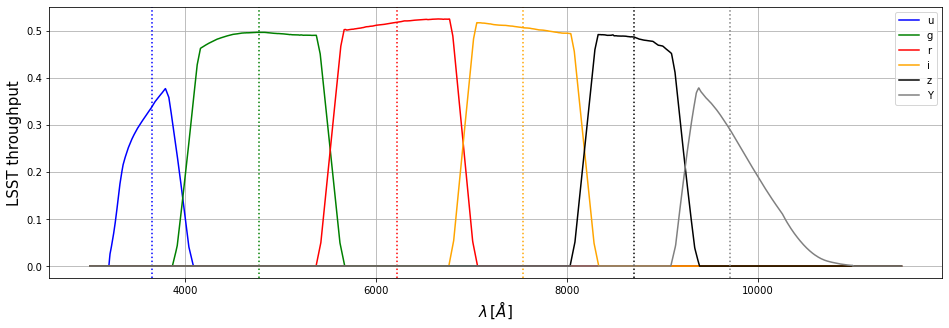

In [72]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for i,filter in enumerate(filters):
    ax.plot(lsst_bp[i].wave,lsst_bp[i].throughput,label=filter_names[i],color=filter_colors[i])
    ax.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('LSST throughput',fontsize=15)
ax.legend()

In [73]:
WLMIN,WLMAX

(3400.0, 10600.0)

In [74]:
wl_b_min = np.min(lsst_bp[0].wave[lsst_bp[0].throughput!=0.])
wl_r_max = np.max(lsst_bp[-1].wave[lsst_bp[-1].throughput!=0.])
print(wl_b_min,wl_r_max)

extra_wls = 2
assert extra_wls%2==0
wl_delta = []
j = 1
Delta_lambda_b = 2
Delta_lambda_r = 8

for i in range(1,extra_wls+1):
    print(i)
    if i<=int(extra_wls/2):
        wl_delta.append(wl_b_min-i*Delta_lambda_b*(wl_eff[1]-wl_eff[0]))
    else: 
        wl_delta.append(wl_r_max+j*Delta_lambda_r*(wl_eff[-1]-wl_eff[-2]))
        j+=1
'''
for i in range(1,extra_wls+1):
    print(i)
    wl_delta.append(wl_r_max+i*(wl_eff[-1]-wl_eff[-2]))
'''
wl_delta = np.sort(wl_delta)

print(wl_delta)
#print(wl_delta0)

3200.0000000000455 10989.000000001815
1
2
[  941.95084527 19047.20224585]


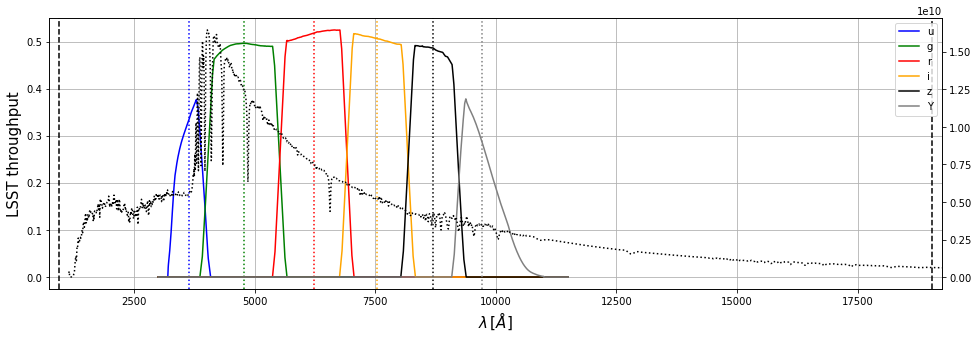

In [75]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
for i,filter in enumerate(filters):
    ax.plot(lsst_bp[i].wave,lsst_bp[i].throughput,label=filter_names[i],color=filter_colors[i])
    ax.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
for l_ in wl_delta:
    ax.axvline(x=l_,ls='--',color='k')
ax2.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls=':',color='k')
ax.set_xlim(wl_delta[0]-200.,wl_delta[-1]+200.)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('LSST throughput',fontsize=15)
ax.legend()

### We compute $M_{\phi}$ by calculating the matrix elements, $\phi^i_b$ 

In [76]:
len(total_passband_ref['u'].throughput)

8501

In [77]:
len(wl)

8501

In [78]:
def phi_ij(wavelength,passband,i):
    
    T_b = passband.throughput
    assert len(wavelength)==len(T_b)
    
    phi_ij = np.trapz(wavelength**(i-1)*T_b,x=wavelength)*Seff*exptime/h_planck
    
    return phi_ij

In [79]:
def phi_ij_delta(wavelength,i):
    
    phi_ij = wavelength**(i-1)*Seff*exptime/h_planck
    
    return phi_ij

In [80]:
phi_ij(wl,total_passband_ref['u'],1)

1.8067928067099206e+35

In [81]:
phi_ij_delta(wl_delta[0],2), phi_ij_delta(wl_delta[-1],2)

(1.381817473429804e+36, 2.794175196649413e+37)

In [82]:
M_phi_std = np.zeros((len(filters),len(filters)))

for i in range(len(filters)):
    for j in range(len(filters)):
        #b = filters[i-int(len(wl_delta)/2)]
        b = filters[i]
        phi_ij_ = phi_ij(wl,total_passband_ref[b],j)
        M_phi_std[i,j] = phi_ij_

M_phi_t_dict = {}

for isim in range(n_sim):
    M_phi_t_ = np.zeros((len(filters),len(filters)))
    
    for i in range(len(filters)):
        for j in range(len(filters)):
            #b = filters[i-int(len(wl_delta)/2)]
            b = filters[i]
            phi_ij_ = phi_ij(wl,total_passband[b][isim],j)
            M_phi_t_[i,j] = phi_ij_
        
    M_phi_t_dict[isim] = M_phi_t_
    

In [83]:
M_phi_std.shape

(6, 6)

In [84]:
M_phi_t_dict[0].shape

(6, 6)

In [85]:
M_phi_inv_std = np.linalg.inv(M_phi_std)

M_phi_inv_t_dict = {}
for isim in range(n_sim):
    M_phi_inv_t_dict[isim] = np.linalg.inv(M_phi_t_dict[isim])



In [86]:
M_phi_inv_std

array([[ 1.37235541e-30, -1.08940384e-30,  1.95336215e-30,
        -2.36529792e-30,  1.71861926e-30, -7.12079605e-31],
       [-1.00932795e-33,  8.61204851e-34, -1.63398409e-33,
         2.04620317e-33, -1.51876142e-33,  6.39125484e-34],
       [ 2.90473756e-37, -2.61524548e-37,  5.25049066e-37,
        -6.82925590e-37,  5.19991743e-37, -2.23075672e-37],
       [-4.09612384e-41,  3.84275393e-41, -8.11952151e-41,
         1.09966875e-40, -8.62644099e-41,  3.78940300e-41],
       [ 2.83469627e-45, -2.74639320e-45,  6.06727200e-45,
        -8.55353434e-45,  6.93901629e-45, -3.13767061e-45],
       [-7.71240148e-50,  7.66649605e-50, -1.75970638e-49,
         2.57677459e-49, -2.16650243e-49,  1.01476241e-49]])

In [87]:
a_vec_std_dict = {}
a_vec_t_dict = {}

for ised in sed_dict.keys():
    phi_std_ = []
    for filter in filters:
        phi_std_.append(phi_std_dict[ised][filter])
    #phi_std_ampli_ = np.array([0]*int(len(wl_delta)/2)+phi_std_+[0]*int(len(wl_delta)/2))
    phi_std_ampli_ = np.array(phi_std_)
    
    a_vec_std_dict[ised] = np.matmul(M_phi_inv_std,phi_std_ampli_)
    
    a_vec_t_dict[ised] = []
    for isim in range(n_sim):
        phi_t_ = []
        for filter in filters:
            phi_t_.append(phi_t_dict[ised][filter][isim])
        #phi_t_ampli_ = np.array([0]*int(len(wl_delta)/2)+phi_t_+[0]*int(len(wl_delta)/2))
        phi_t_ampli_ = np.array(phi_t_)
        
        a_vec_t_dict[ised].append(np.matmul(M_phi_inv_t_dict[isim],phi_t_ampli_))
    
#print(a_vec_std_dict)

In [88]:
len(a_vec_t_dict[example_id][0])

6

In [89]:
def poly_f(l,a,fluxunits='photlam'):
    val_ = 0.
    for i in range(len(a)):
        val_ = val_+a[i]*l**i
    
    if fluxunits=='fnu':
        A = 1.
    elif fluxunits=='flam':
        A = c_light/l**2.
    elif fluxunits=='photlam':
        A = 1./(h_planck*l)
    else:
        A = 1.
    val_ = A*val_
    
    return val_

In [90]:
poly_spec_std_dict = {}
poly_spec_t_dict = {}

for ised in sed_dict.keys():
    poly_spec_std_dict[ised] = poly_f(wl,a_vec_std_dict[ised])
    
    poly_spec_t_dict[ised] = []
    for isim in range(n_sim):
        poly_spec_t_dict[ised].append(poly_f(wl,a_vec_t_dict[ised][isim]))

In [91]:
example_spec.fluxunits

In [92]:
poly_spec_std_dict[example_id]

array([-1714.09872827, -1707.29667686, -1700.50648497, ...,
        1247.59462566,  1249.00597292,  1250.41882788])

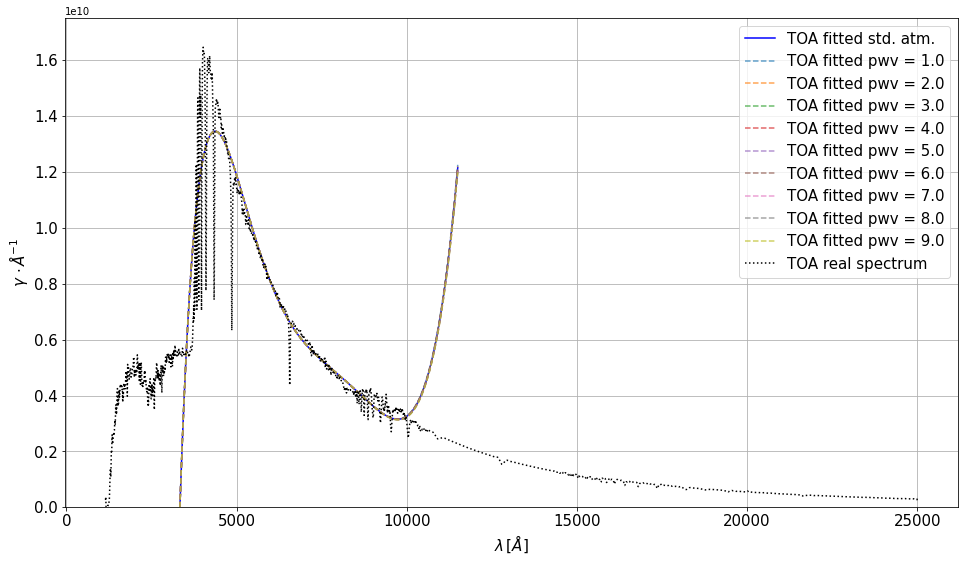

In [93]:
fig=plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.plot(wl,poly_spec_std_dict[example_id]*Seff*exptime,ls='-',color='b',label='TOA fitted std. atm.')
for isim in range(n_sim):
    ax.plot(wl,poly_spec_t_dict[example_id][isim]*Seff*exptime,ls='--',alpha=0.7,label='TOA fitted {0} = {1}'.format(variable_param,atm_vals[isim]))

ax.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls=':',color='k',label='TOA real spectrum')
#ax.set_xlim(WLMIN,WLMAX)
#ax.set_xlim(9000,10500)
ax.set_ylim(0.,1.75e10)
#ax.set_ylim(0,0.4e10)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)



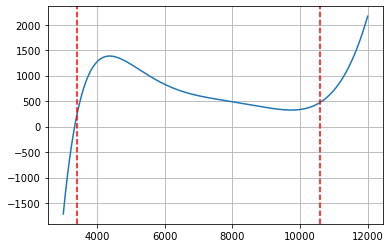

In [94]:
plt.plot(np.arange(wl[0],12000.),poly_f(np.arange(wl[0],12000.),a_vec_std_dict[example_id]))
plt.axvline(x=WLMIN,ls='--',color='r')
plt.axvline(x=WLMAX,ls='--',color='r')
plt.grid()

In [95]:
xpoints = [wl_delta[0]]
ypoints = [0.]
for filter in filters:
    leff_ = eff_lambda[filter]
    xpoints.append(leff_)
    poly_val_ = poly_f(leff_,a_vec_std_dict[example_id])
    ypoints.append(poly_val_)
xpoints.append(wl_delta[-1])
ypoints.append(0.)
xpoints = np.array(xpoints)
ypoints = np.array(ypoints)

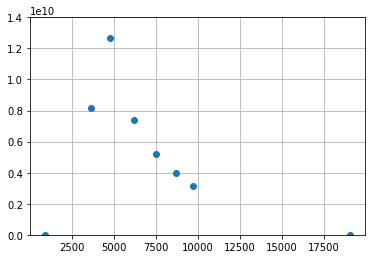

In [96]:
plt.plot(xpoints,ypoints*Seff*exptime,ls='',marker='o')
plt.ylim(0.,1.4e10)
plt.grid()

In [97]:
wl_delta

array([  941.95084527, 19047.20224585])

In [98]:
from scipy.interpolate import splrep, BSpline

In [99]:
tck = splrep(xpoints, ypoints, s=0)
tck_s = splrep(xpoints, ypoints, s=len(xpoints))
tck2 = splrep(xpoints, ypoints, s=0, k=2)
tck4 = splrep(xpoints, ypoints, s=0, k=4)

In [100]:
xnew = np.linspace(wl_delta[0],wl_delta[-1],100000)

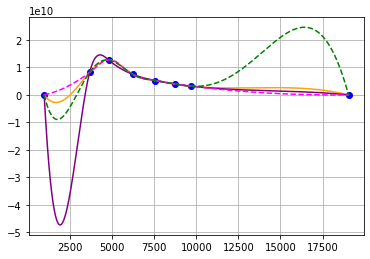

In [101]:
plt.plot(xpoints,ypoints*Seff*exptime,ls='',marker='o',color='b')
plt.plot(xnew,BSpline(*tck)(xnew)*Seff*exptime,ls='-',color='orange')
plt.plot(xnew,BSpline(*tck_s)(xnew)*Seff*exptime,ls='-',color='purple')
plt.plot(xnew,BSpline(*tck2)(xnew)*Seff*exptime,ls='--',color='magenta')
plt.plot(xnew,BSpline(*tck4)(xnew)*Seff*exptime,ls='--',color='g')
#plt.ylim(0.,1.4e10)
plt.grid()

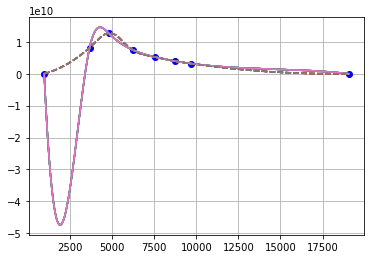

In [102]:
plt.plot(xpoints,ypoints*Seff*exptime,ls='',marker='o',color='b')
for s_ in range(0,len(xpoints)+1):
    tck_ = splrep(xpoints, ypoints, s=i,k=3)
    tck2_ = splrep(xpoints, ypoints, s=i,k=2)
    
    #print(BSpline(*tck2_)(xnew))
    plt.plot(xnew,BSpline(*tck_)(xnew)*Seff*exptime,ls='-')
    plt.plot(xnew,BSpline(*tck2_)(xnew)*Seff*exptime,ls='--')
plt.grid()

[-0.06549711 -0.03999393 -0.0144866  ... -0.00241781 -0.00109494
  0.00022822]
[-0.06549711 -0.03999393 -0.0144866  ... -0.00241781 -0.00109494
  0.00022822]
[-0.06549711 -0.03999393 -0.0144866  ... -0.00241781 -0.00109494
  0.00022822]
[-0.06549711 -0.03999393 -0.0144866  ... -0.00241781 -0.00109494
  0.00022822]
[-0.06549711 -0.03999393 -0.0144866  ... -0.00241781 -0.00109494
  0.00022822]
[-0.06549711 -0.03999393 -0.0144866  ... -0.00241781 -0.00109494
  0.00022822]
[-0.06549711 -0.03999393 -0.0144866  ... -0.00241781 -0.00109494
  0.00022822]
[-0.06549711 -0.03999393 -0.0144866  ... -0.00241781 -0.00109494
  0.00022822]
[-0.06549711 -0.03999393 -0.0144866  ... -0.00241781 -0.00109494
  0.00022822]


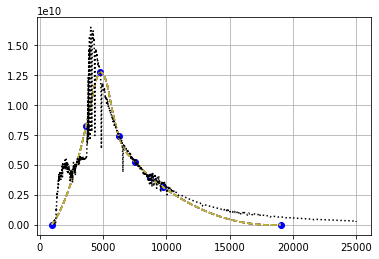

In [103]:
plt.plot(xpoints,ypoints*Seff*exptime,ls='',marker='o',color='b')
for s_ in range(0,len(xpoints)+1):
    tck2_ = splrep(xpoints, ypoints, s=i,k=2)
    
    print(BSpline(*tck2_)(xnew))
    plt.plot(xnew,BSpline(*tck2_)(xnew)*Seff*exptime,ls='--')
plt.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls=':',color='k',label='TOA real spectrum')
plt.grid()

In [104]:
def logi_fun(x,x0,a,m,n,tau):
    num = 1.+m*np.exp(-(x-x0)/tau)
    den = 1.+n*np.exp(-(x-x0)/tau)
    return a*num/den

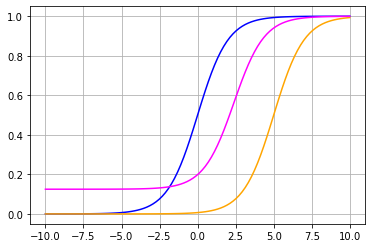

In [105]:
x_ = np.linspace(-10,10,100)
plt.plot(x_,logi_fun(x_,0,1,0,1,1),color='b')
plt.plot(x_,logi_fun(x_,5,1,0,1,1),color='orange')
#plt.plot(x_,logi_fun(x_,0,1,1,1,1),color='purple')
plt.plot(x_,logi_fun(x_,1,1,0.5,4,1),color='magenta')
plt.grid()

In [106]:
def exp_fun(x,A,k):
    return A*np.exp(k*x)

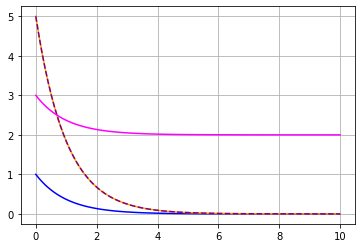

In [107]:
plt.plot(np.linspace(0,10,100),exp_fun(np.linspace(0,10,100),1,-1),color='b')
plt.plot(np.linspace(0,10,100),exp_fun(np.linspace(0,10,100),5,-1),color='orange')
plt.plot(np.linspace(0.0001,10,100),exp_fun(np.linspace(0.0001,10,100)-np.log(5),1,-1),ls='--',color='purple')
plt.plot(np.linspace(0,10,100),exp_fun(np.linspace(0,10,100),1,-1)+2.,color='magenta')
plt.grid()

In [108]:
def super_fun(wl,C,wl0,k,m,n,tau1,tau2):
    num = np.exp(-k*(wl-wl0))+m*np.exp(-(k+1./tau1)*(wl-wl0))
    den = 1.+n*np.exp(-(wl-wl0)/tau2)
    return C*num/den

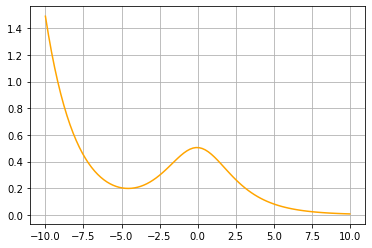

In [109]:
#plt.plot(x_,super_fun(x_,1,1,1,1,1),color='b')
plt.plot(x_,super_fun(x_,1,0,0.5,0.01,1,1,1),color='orange')
plt.grid()

## Tests with each parameter 

### Varying *k* 

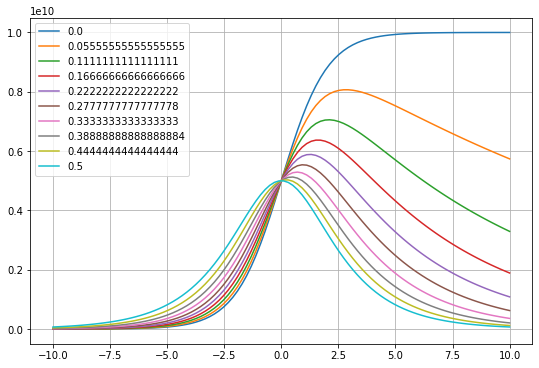

In [110]:
C_ = 1e10
wl0_ = 0.
m_ = 0.
n_ = 1. 
tau1_ = 1.
tau2_ = 1.
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
for k_ in np.linspace(0,0.5,10):
    ax.plot(x_,super_fun(x_,C_,wl0_,k_,m_,n_,tau1_,tau2_),label=k_)

#plt.xlim(0,10)
#plt.ylim(0,100)
ax.grid()
ax.legend(loc="best")

### Varying *m* 

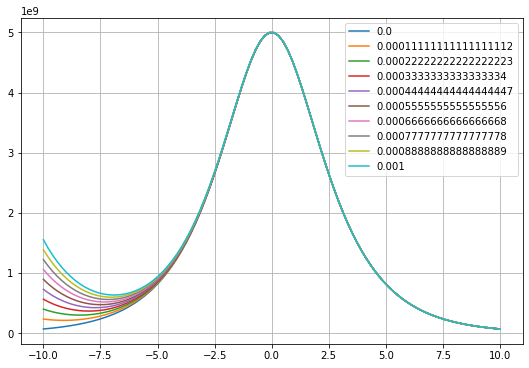

In [111]:
C_ = 1e10
wl0_ = 0.
k_ = 0.5
n_ = 1. 
tau1_ = 1.
tau2_ = 1.
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
for m_ in np.linspace(0,0.001,10):
    ax.plot(x_,super_fun(x_,C_,wl0_,k_,m_,n_,tau1_,tau2_),label=m_)
#plt.plot(x_,exp_fun(x_,50,-0.5),ls=':',color='k')
#plt.xlim(0,10)
#plt.ylim(0,100)
ax.grid()
ax.legend(loc="best")

### Varying *n* 

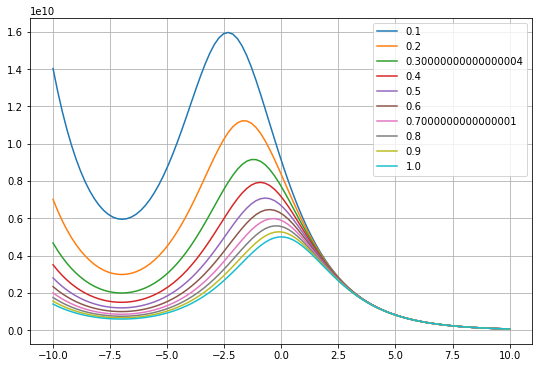

In [112]:
C_ = 1e10
k_ = 0.5
wl0_ = 0.
m_ = 0.0009
tau1_ = 1.
tau2_ = 1.
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
for n_ in np.linspace(0.1,1,10):
    ax.plot(x_,super_fun(x_,C_,wl0_,k_,m_,n_,tau1_,tau2_),label=n_)
#plt.xlim(0,10)
#plt.ylim(0,100)
ax.grid()
ax.legend(loc="best")

### Varying $\tau_1$ 

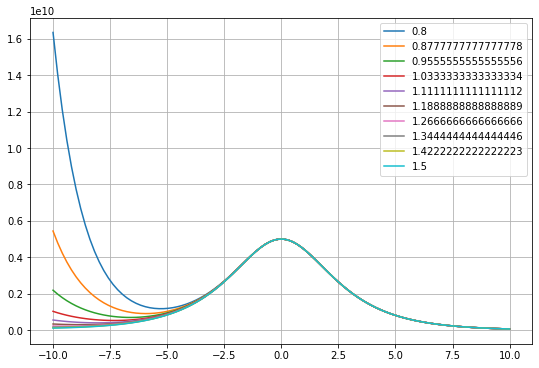

In [113]:
C_ = 1e10
wl0_ = 0.
k_ = 0.5
m_ = 0.0009
n_ = 1.
tau2_ = 1.
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
for tau1_ in np.linspace(0.8,1.5,10):
    ax.plot(x_,super_fun(x_,C_,wl0_,k_,m_,n_,tau1_,tau2_),label=tau1_)
#plt.xlim(0,10)
#plt.ylim(0,100)
ax.grid()
ax.legend(loc="best")

### Varying $\tau_2$ 

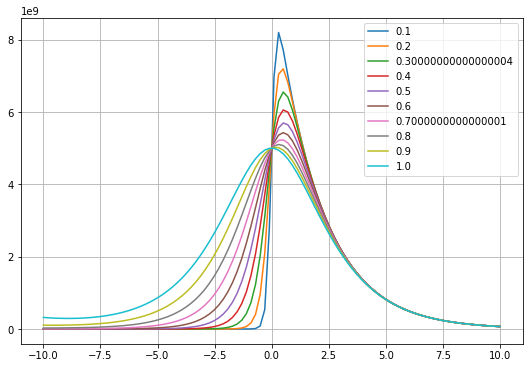

In [114]:
C_ = 1e10
wl0_ = 0.
k_ = 0.5
m_ = 0.0009
n_ = 1.
tau1_ = 1.2
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
for tau2_ in np.linspace(0.1,1,10):
    ax.plot(x_,super_fun(x_,C_,wl0_,k_,m_,n_,tau1_,tau2_),label=tau2_)
#plt.xlim(0,10)
#plt.ylim(0,100)
ax.grid()
ax.legend(loc="best")

### Varying *C* 

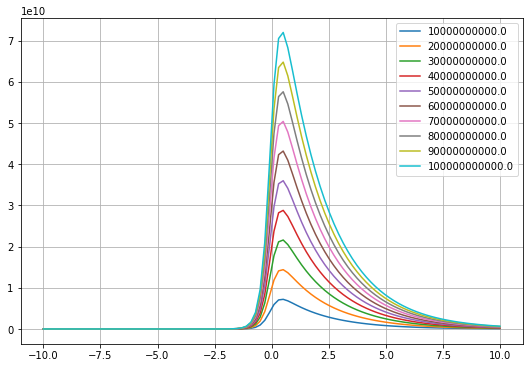

In [115]:
wl0_ = 0.
k_ = 0.5
m_ = 0.0009
n_ = 1.
tau1_ = 1.2
tau2_ = 0.2
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
for C_ in np.linspace(1e10,10e10,10):
    ax.plot(x_,super_fun(x_,C_,wl0_,k_,m_,n_,tau1_,tau2_),label=C_)
#plt.xlim(0,10)
#plt.ylim(0,100)
ax.grid()
ax.legend(loc="best")

### Varying $\lambda_0$ 

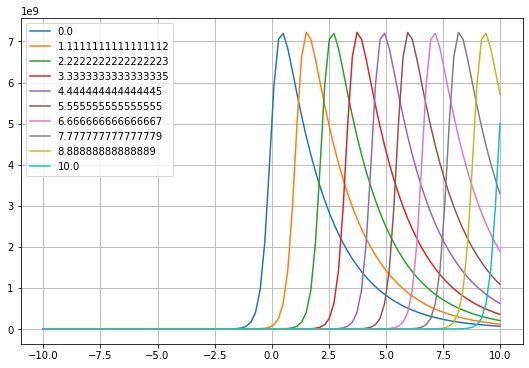

In [116]:
C_ = 1e10
k_ = 0.5
m_ = 0.0009
n_ = 1.
tau1_ = 1.2
tau2_ = 0.2
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
for wl0_ in np.linspace(0,10,10):
    ax.plot(x_,super_fun(x_,C_,wl0_,k_,m_,n_,tau1_,tau2_),label=wl0_)
#plt.xlim(0,10)
#plt.ylim(0,100)
ax.grid()
ax.legend(loc="best")

### We create an artificial SED with the logistic function 

In [122]:
waveunits

'angstrom'

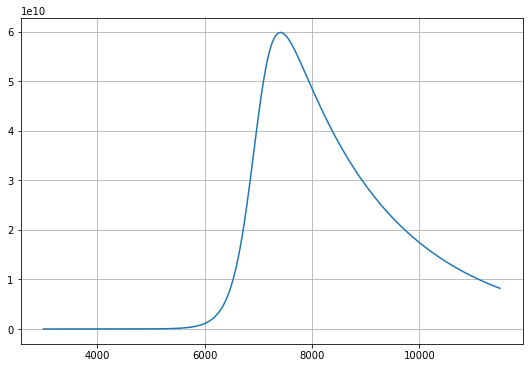

In [124]:
C0 = 8e3
wl0 = 7000.
k0 = 0.5e-3
m0 = 0.1
n0 = 1
tau10 = 1e3
tau20 = 0.2e3
logi_sed = super_fun(wl,C0,wl0,k0,m0,n0,tau10,tau20)

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(wl,logi_sed*Seff*exptime)
ax.grid()

In [125]:
logi_spec = S.ArraySpectrum(wl,logi_sed)

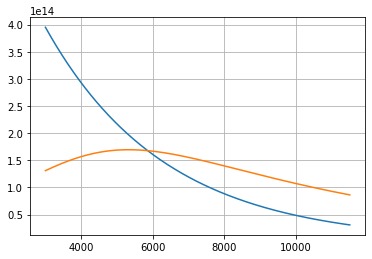

In [126]:
plt.plot(wl,super_fun(wl,1e8,0,0.0003,15.7,10.1,20.2,21.1)*Seff*exptime)
plt.plot(wl,super_fun(wl,0.5e8,0,0.00015,15.7,10.1,5.2,1500.1)*Seff*exptime)
#plt.yscale("log")
plt.grid()

In [127]:
eff_wl = []
phi0 = []
phi0_err = []
for filter in filters:
    eff_wl.append(eff_lambda[filter])
    phi0_,phi0_err_ = int_flux(logi_spec,total_passband_ref[filter],return_error=True)
    phi0.append(phi0_)
    phi0_err.append(phi0_err_)
eff_wl = np.array(eff_wl)
phi0 = np.array(phi0)
phi0_err = np.array(phi0_err)

n_i =  [7.65061544e+03 7.67862860e+03 7.70674533e+03 ... 8.21356752e+09
 8.20945264e+09 8.20533983e+09]
n_i =  [7.65061544e+03 7.67862860e+03 7.70674533e+03 ... 8.21356752e+09
 8.20945264e+09 8.20533983e+09]
n_i =  [7.65061544e+03 7.67862860e+03 7.70674533e+03 ... 8.21356752e+09
 8.20945264e+09 8.20533983e+09]
n_i =  [7.65061544e+03 7.67862860e+03 7.70674533e+03 ... 8.21356752e+09
 8.20945264e+09 8.20533983e+09]
n_i =  [7.65061544e+03 7.67862860e+03 7.70674533e+03 ... 8.21356752e+09
 8.20945264e+09 8.20533983e+09]
n_i =  [7.65061544e+03 7.67862860e+03 7.70674533e+03 ... 8.21356752e+09
 8.20945264e+09 8.20533983e+09]


In [130]:
def sed_model(theta,wl=wl):
    C_,wl0_,k_,m_,n_,tau1_,tau2_ = theta
    '''
    num = C*np.exp(-k*(wl-wl0))*(1.+m*np.exp(-(wl-wl0)/tau1))
    den = 1.+n*np.exp(-(wl-wl0)/tau2)
    logi_spec_ = num/den
    '''
    model_spec_ = super_fun(wl,C_,wl0_,k_,m_,n_,tau1_,tau2_)
    
    model_spec_ = S.ArraySpectrum(wl,model_spec_)
    
    return model_spec_


In [131]:
def phi_model(theta,eff_wl=eff_wl):
    model_spec_ = sed_model(theta)
    model = []
    for filter in filters:
        model.append(int_flux(model_spec_,total_passband_ref[filter]))
    model = np.array(model)
    
    return model

### We create a test spectrum with the new function and we also compute the $\Phi_b$'s 

In [146]:
C0 = 8e3
wl0 = 5000.
k0 = 0.5e-3
m0 = 0.1
n0 = 1
tau10 = 1e3
tau20 = 0.2e3
theta0 = [C0,wl0,k0,m0,n0,tau10,tau20]
sed0 = sed_model(theta0,wl)
phi0 = phi_model(theta0,wl)

Text(0, 0.5, '$T_b$')

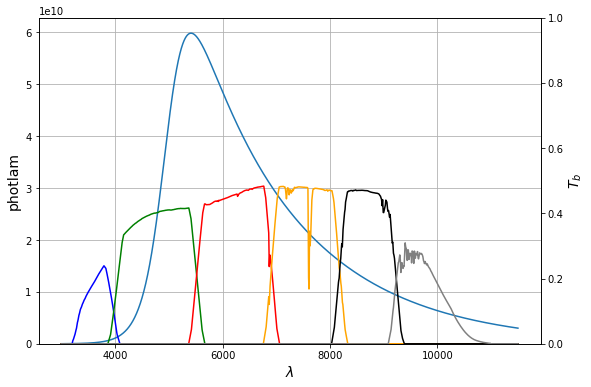

In [147]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(wl,sed0.flux*Seff*exptime)
ax.set_ylim(0.)
ax.grid()
ax.set_xlabel(r'$\lambda$',fontsize=14)
ax.set_ylabel('photlam',fontsize=14)
ax2 = ax.twinx()
for i,filter in enumerate(filters):
    ax2.plot(total_passband_ref[filter].wave,total_passband_ref[filter].throughput,ls='-',color=filter_colors[i])
ax2.set_ylim(0.,1.)
ax2.set_ylabel(r'$T_b$',fontsize=14)

Text(0, 0.5, '$\\Phi_b$')

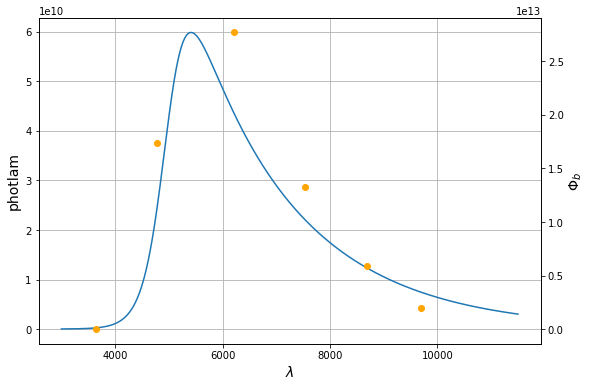

In [149]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(wl,sed0.flux*Seff*exptime)
ax.grid()
ax.set_xlabel(r'$\lambda$',fontsize=14)
ax.set_ylabel('photlam',fontsize=14)
ax2 = ax.twinx()
ax2.plot(eff_wl,phi0,ls='',marker='o',color='orange')
ax2.set_ylabel(r'$\Phi_b$',fontsize=14)

In [150]:
int_flux(logi_spec,total_passband_ref['i'],return_error=True)

n_i =  [7.65061544e+03 7.67862860e+03 7.70674533e+03 ... 8.21356752e+09
 8.20945264e+09 8.20533983e+09]


(30825066617769.85, 3699078.4011449176)

In [151]:
def log_likelihood(theta,eff_wl,phi,phi_err):
    phi_model_ = phi_model(theta,eff_wl)
    log_like = -0.5*np.sum(((phi-phi_model_)/phi_err)**2.)
    return log_like

In [152]:
theta0

[8000.0, 5000.0, 0.0005, 0.1, 1, 1000.0, 200.0]

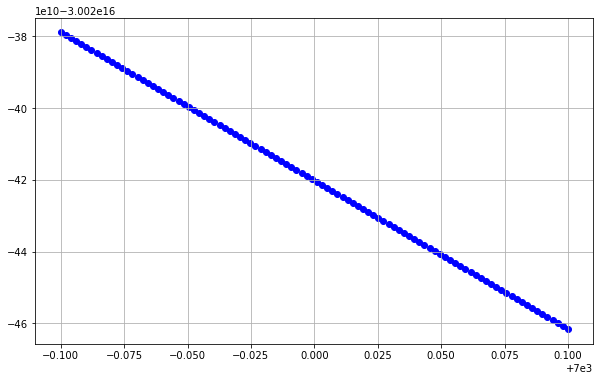

In [153]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for wl_ in np.linspace(6999.9,7000.1,100):
    theta_in_ = [C0,wl_,k0,m0,n0,tau10,tau20]
    log_like_ = log_likelihood(theta_in_,eff_wl,phi0,phi0_err)
    ax.scatter(wl_,log_like_,marker='o',color='b')
ax.grid()

In [138]:
from scipy.optimize import minimize

In [226]:
initial = np.array([7.5e3,7000.,0.45e-3,0.12,1.1,0.95e3,0.25e3])
#initial = np.array(list(theta0)+[np.log(3e13)])
#initial = theta0

In [227]:
theta0

[8000.0, 7000.0, 0.0005, 0.1, 1, 1000.0, 200.0]

In [228]:
nll = lambda *args: -log_likelihood(*args)
soln = minimize(nll, initial, args=(eff_wl,phi0,phi0_err))
#soln = minimize(nll, initial, args=(eff_wl,phi0,np.ones(len(phi0))))
soln.x

/tmp/ipykernel_133550/2653691273.py:3: RuntimeWarning: overflow encountered in exp
  num = C*np.exp(-k*(wl-wl0))*(1.+m*np.exp(-(wl-wl0)/tau1))
/tmp/ipykernel_133550/2653691273.py:3: RuntimeWarning: overflow encountered in multiply
  num = C*np.exp(-k*(wl-wl0))*(1.+m*np.exp(-(wl-wl0)/tau1))
/home/martin/anaconda3/envs/python38/lib/python3.8/site-packages/pysynphot/spectrum.py:886: RuntimeWarning: invalid value encountered in multiply
  return self.component1(wavelength) * self.component2(wavelength)
/home/martin/anaconda3/envs/python38/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_133550/2653691273.py:3: RuntimeWarning: overflow encountered in exp
  num = C*np.exp(-k*(wl-wl0))*(1.+m*np.exp(-(wl-wl0)/tau1))
/tmp/ipykernel_133550/2653691273.py:3: RuntimeWarning: overflow encountered in multiply
  num = C*np.exp(-k*(wl-wl0))*(1.+m*np.exp(-(wl-wl0)/tau1))
/home/martin/anaconda3/envs/python3

array([7.5e+03, 7.0e+03, 4.5e-04, 1.2e-01, 1.1e+00, 9.5e+02, 2.5e+02])

In [229]:
CC,wll0,kk,mm,nn,tt1,tt2 = soln.x

In [230]:
theta_ = [CC,wll0,kk,mm,nn,tt1,tt2]
print(theta0)
print(theta_)
print(np.array(theta0)-np.array(theta_))

[8000.0, 7000.0, 0.0005, 0.1, 1, 1000.0, 200.0]
[7500.0, 7000.0, 0.00045, 0.12, 1.1, 950.0, 250.0]
[ 5.e+02  0.e+00  5.e-05 -2.e-02 -1.e-01  5.e+01 -5.e+01]


In [231]:
phi_model(theta0,eff_wl)

array([1.43782283e+07, 1.50353713e+10, 5.00451899e+12, 3.08250666e+13,
       1.63496684e+13, 5.37412874e+12])

In [232]:
phi0

array([1.43782283e+07, 1.50353713e+10, 5.00451899e+12, 3.08250666e+13,
       1.63496684e+13, 5.37412874e+12])

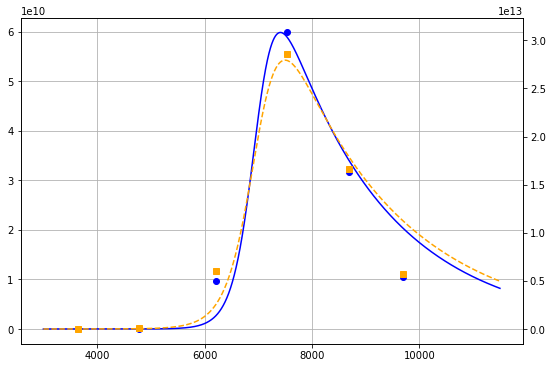

In [233]:
C0, wl0, k0, m0, n0, tau10, tau20 = theta0
C_, wl_, k_, m_, n_, tau1_, tau2_ = theta_
logi_sed = super_fun(wl,C0,wl0,k0,m0,n0,tau10,tau20)
fitted_sed = super_fun(wl,*theta_)

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(wl,logi_sed*Seff*exptime,color='b')
ax.plot(wl,fitted_sed*Seff*exptime,ls='--',color='orange')
ax.grid()

ax2 = ax.twinx()
phi0 = phi_model(theta0,wl)
fitted_phi = phi_model(theta_,wl)
ax2.plot(eff_wl,phi0,ls='',marker='o',color='b')
ax2.plot(eff_wl,fitted_phi,ls='',marker='s',color='orange')

In [205]:
phi0_err

array([1.59098904e+03, 7.13220339e+04, 1.42403001e+06, 3.69907840e+06,
       2.62070222e+06, 1.09471633e+06])

In [301]:
def lnlike(theta,x,y,yerr):
    ymodel = sed_model(theta,x)
    LnLike = -0.5*np.sum(((y-ymodel)/yerr)**2.)
    return LnLike

In [305]:
np.mean(wl)

7250.000000000967

In [324]:
def lnprior(theta):
    C,wl0,k,m,n,tau1,tau2 = theta
    if 7e3<C<9e3 and 3000.<wl0<12000. and 0.5e-4<k<0.5e-2 and 1e-2<m<9e-1 and 0.5<n<1.5 and 9e2<tau1<1.2e4 and 0.1e3<tau2<0.1e4:
        return 0.0
    else:
        return -np.inf

In [307]:
def lnprob(theta,x,y,yerr):
    lp = lnprior(theta)
    if not np.isinf(lp):
        return -np.inf
    return lp+lnlike(theta,x,y,yerr)

In [323]:
print(eff_lambda_vec,logi_phi,logi_err)

[3646.6653725477827, 4775.689949910929, 6221.858748950202, 7538.742212119657, 8695.989905566856, 9703.26518629804] [14378228.27056396, 15035371277.13396, 5004518988049.471, 30825066617769.85, 16349668434118.3, 5374128742759.184] [1590.9890360709462, 71322.03390667305, 1424030.010278916, 3699078.4011449176, 2620702.2237411137, 1094716.332915265]


### We make the polynomial spectrum pass through the different total passbands 

**NOTE:** for each object $\mu$ and for each atmospheric condition (standard and non-standard) we compute a $\hat{F}_i(\lambda)$, because this is what we will actually have at each moment. That is, $\hat{F}_i(\lambda) = \hat{F}_i(\lambda ; std)$ or $ \hat{F}_i(\lambda ; t)$. 

We pass the **estimated spectra** through the **standard atmosphere**, so we obtain what we call $\vec{\Phi}^{std}_i$. **Note that we will have one $\vec{\Phi}^{std}_i$ from each estimated $\hat{F}_i(\lambda)$, that is, for each $\vec{\varphi}_i(t)$.** 

For the two extreme cases (minimum and maximum total passbands), we pass the corresponding estimated spectra through the corresponding atmosphere, obtaining what we refer to as $\vec{\Phi}_i(t)$, that is, the **estimated spectrum** passing through the **current atmosphere**. It could also happen that the current atmosphere is equal to the standard one. In that case, $\vec{\Phi}_i(t)$ will be equal to $\vec{\Phi}^{std}_i$ and therefore the corrected flux, $\vec{\varphi}^{\, corr}_i$, will be equal to the observed one $\vec{\varphi}_i(t)$. 


### Set up the polynomial spectra in pysynphot format 

In [112]:
poly_dict = {}

for ised in sed_dict.keys():
    poly_dict[ised] = {}
    poly0_ = S.ArraySpectrum(wl,poly_spec_std_dict[ised])
    poly_dict[ised]['std'] = poly0_
    
    for isim in range(n_sim):
        poly0_ = S.ArraySpectrum(wl,poly_spec_t_dict[ised][isim])
        poly_dict[ised][isim] = poly0_
        
    

Warning, 84 of 8501 bins contained negative fluxes; they have been set to zero.
Warning, 84 of 8501 bins contained negative fluxes; they have been set to zero.
Warning, 84 of 8501 bins contained negative fluxes; they have been set to zero.
Warning, 84 of 8501 bins contained negative fluxes; they have been set to zero.
Warning, 84 of 8501 bins contained negative fluxes; they have been set to zero.
Warning, 84 of 8501 bins contained negative fluxes; they have been set to zero.
Warning, 84 of 8501 bins contained negative fluxes; they have been set to zero.
Warning, 84 of 8501 bins contained negative fluxes; they have been set to zero.
Warning, 84 of 8501 bins contained negative fluxes; they have been set to zero.
Warning, 84 of 8501 bins contained negative fluxes; they have been set to zero.
Warning, 182 of 8501 bins contained negative fluxes; they have been set to zero.
Warning, 182 of 8501 bins contained negative fluxes; they have been set to zero.
Warning, 182 of 8501 bins contained ne

### Compute the $\hat{F}(\lambda;t)$ through the corresponding **current atmosphere** 

**Note:** we store separately the $\hat{F}(\lambda;std)$ spectra through the standard atmosphere just for checking purposes 

In [113]:

obs_poly_std_dict = {}
obs_poly_t_dict = {}

for ised in sed_dict.keys():
    obs_poly_std_dict[ised] = {}
    obs_poly_t_dict[ised] = {}
    for filter in filters:
        poly_total_ = S.Observation(poly_dict[ised]['std'],total_passband_ref[filter],force='taper')
        obs_poly_std_dict[ised][filter] = poly_total_
        
        obs_poly_t_dict[ised][filter] = []
        for isim in range(n_sim):
            poly_total_ = S.Observation(poly_dict[ised][isim],total_passband[filter][isim],force='taper')
            obs_poly_t_dict[ised][filter].append(poly_total_)
            
    

### Compute the $\hat{F}(\lambda;t)$ through the **standard atmosphere** 

In [114]:
std_poly_t_dict = {}

for ised in sed_dict.keys():
    
    std_poly_t_dict[ised] = {}
    
    for filter in filters:
        std_poly_t_dict[ised][filter] = []
        for isim in range(n_sim):
            poly_cross_ = S.Observation(poly_dict[ised][isim],total_passband_ref[filter],force='taper')
            std_poly_t_dict[ised][filter].append(poly_cross_)
        
    

In [115]:
std_poly_t_dict[example_id][filter]

u
g
r
i
z
Y
photlam


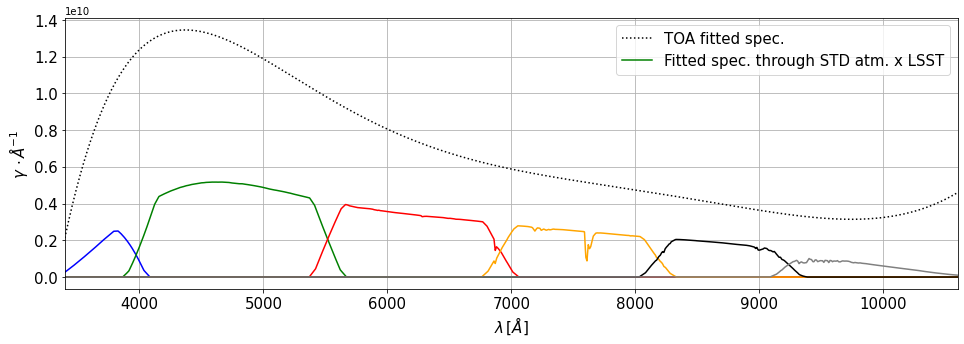

In [116]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

ax.plot(poly_dict[example_id][4].wave,poly_dict[example_id][4].flux*Seff*exptime,ls=':',color='k',alpha=1.0)
#ax.plot(poly_atm_std.binwave,poly_atm_std.binflux*Seff*exptime,ls='--',color='cyan',alpha=1.0)

for index,filter in enumerate(filters):
    print(filter)
    obs = std_poly_t_dict[example_id][filter][4]
    ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)

ax.set_xlim(WLMIN,WLMAX)
#ax.set_ylim(0.,0.5e13)
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA fitted spec.')
ax.plot([],[],ls='-',color='g',label='Fitted spec. through STD atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

u
g
r
i
z
Y
photlam


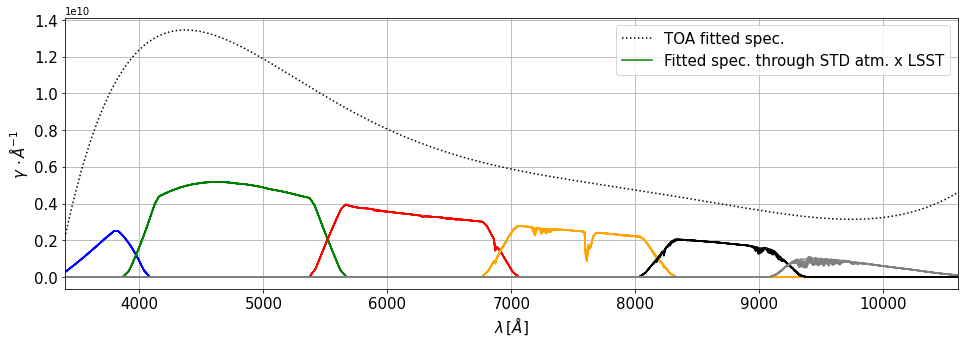

In [117]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

ax.plot(poly_dict[example_id][4].wave,poly_dict[example_id][4].flux*Seff*exptime,ls=':',color='k',alpha=1.0)
#ax.plot(poly_atm_std.binwave,poly_atm_std.binflux*Seff*exptime,ls='--',color='cyan',alpha=1.0)

for index,filter in enumerate(filters):
    print(filter)
    for isim in range(n_sim):
        obs = obs_poly_t_dict[example_id][filter][isim]
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)

ax.set_xlim(WLMIN,WLMAX)
#ax.set_xlim(9000,11000)
#ax.set_ylim(0.,0.2e10)
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA fitted spec.')
ax.plot([],[],ls='-',color='g',label='Fitted spec. through STD atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

## IMPORTANT NOTE: 

All the following integrated spectra correspond to $\vec{\Phi}_i(t)$, that is, to each estimated $\hat{F}_i(\lambda;t)$ passing through the atmosphere they were inferred from, i.e. the current atmosphere. **This includes the standard atmosphere case.** This is so because, as we mentioned before, one possible situation is that the current atmosphere corresponds to the standard one. WE MUST NOT interpret the following integrated fluxes as the different $\vec{\Phi}_i^{std}$ vectors, which will correspond to the different $\hat{F}_i(\lambda;t)$ passing through the standard atmosphere. 


Compute the $\vec{\Phi}_i(t)$ values. We also compute the magnitudes obtained from $\vec{\Phi}_i(t)$ as 

$$\vec{\mathbb{m}}_i(t) = -2.5 \log_{10} \frac{\vec{\Phi}_i(t)}{\Phi_{AB}} \, . $$ 

In [118]:
Phi_t_dict = {}
Mag_t_dict = {}

for ised in sed_dict.keys():
    Phi_t_dict[ised] = {}
    Mag_t_dict[ised] = {}
    for index,filter in enumerate(filters):
        Phi_t_dict[ised][filter] = []
        Mag_t_dict[ised][filter] = []
        for isim in range(n_sim):
            num_,mag_ = int_flux(poly_dict[ised][isim],total_passband[filter][isim],return_mag=True,PhiAB=Phi_AB[index])
            Phi_t_dict[ised][filter].append(num_)
            Mag_t_dict[ised][filter].append(mag_)
        
    
    

Compute the $\vec{\Phi}_i^{std}$ values. Similarly, we also calculate the magnitudes obtained from $\vec{\Phi}_i^{std}$ as 

$$\vec{\mathbb{m}}_i^{std} = -2.5 \log_{10} \frac{\vec{\Phi}_i^{std}}{\Phi_{AB}} \, . $$ 

In [119]:
Phi_std_dict = {}
Mag_std_dict = {}

for ised in sed_dict.keys():
    Phi_std_dict[ised] = {}
    Mag_std_dict[ised] = {}
    for index,filter in enumerate(filters):
        Phi_std_dict[ised][filter] = []
        Mag_std_dict[ised][filter] = []
        for isim in range(n_sim):
            num_,mag_ = int_flux(poly_dict[ised][isim],total_passband_ref[filter],return_mag=True,PhiAB=Phi_AB[index])
            Phi_std_dict[ised][filter].append(num_)
            Mag_std_dict[ised][filter].append(mag_)
        
    

### Comparison plots with respect to **standard (reference) atmosphere** 

We compare the integrated flux obtained from the **real spectrum** and the **fitted one** 

photlam


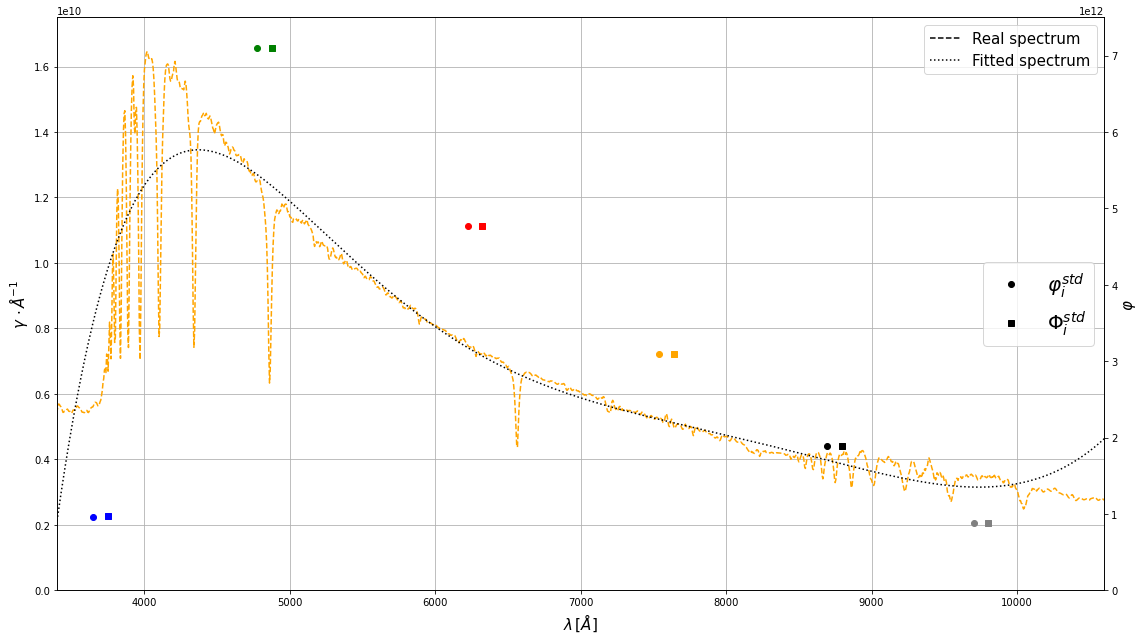

In [120]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls='--',color='orange',alpha=1.0)
ax1.plot(poly_dict[example_id]['std'].wave,poly_dict[example_id]['std'].flux*Seff*exptime,ls=':',color='k',alpha=1.0)

ax2 = ax1.twinx()
    
ax1.set_xlim(WLMIN,WLMAX)
ax1.set_ylim(0.,1.75e10)
ax2.set_ylim(0,7.5e12)
ax1.plot([],[],ls='--',color='k',label='Real spectrum')
ax1.plot([],[],ls=':',color='k',label='Fitted spectrum')
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()

for index,filter in enumerate(filters):
    ax2.scatter(eff_lambda[filter],phi_std_dict[example_id][filter],marker='o',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter]+100.,Phi_std_dict[example_id][filter][4],marker='s',color=filter_colors[index])

ax2.plot([],[],ls='',marker='o',color='k',label=r'$\varphi^{std}_i$')
ax2.plot([],[],ls='',marker='s',color='k',label=r'$\Phi^{std}_i$')
ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=15)
ax2.legend(fontsize=20,loc='center right')
plt.tight_layout()
print(spec.fluxunits)

### And now we compare with the integrated fluxes from the real spectrum for each atmospheric situation 

photlam


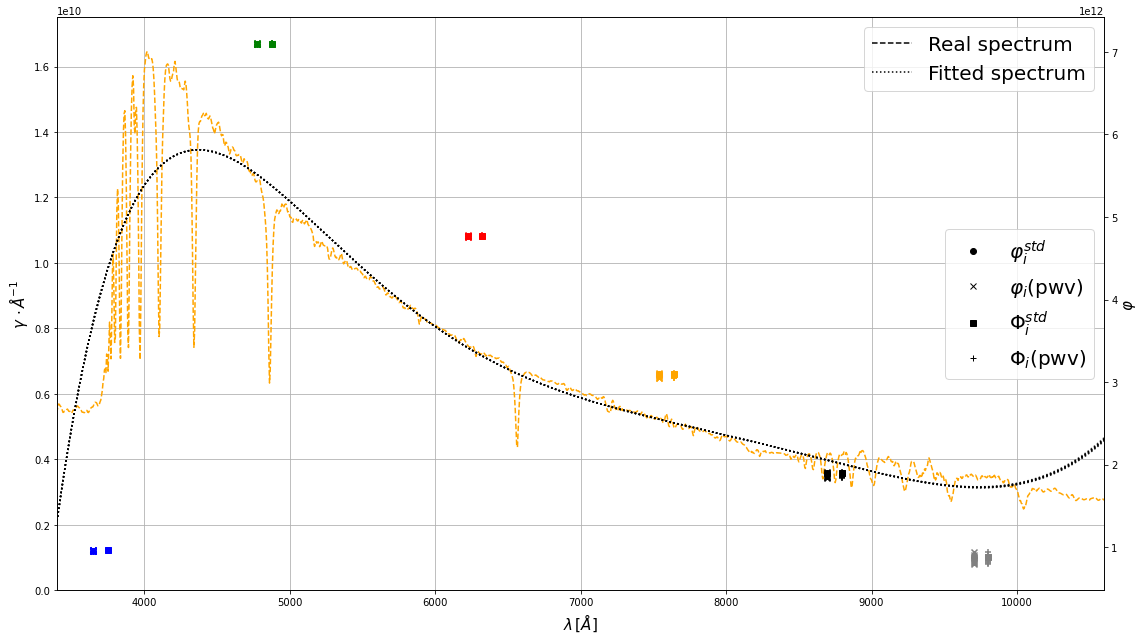

In [121]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(sed_dict[example_id].wave,example_spec.flux*Seff*exptime,ls='--',color='orange',alpha=1.0)
ax1.plot(poly_dict[example_id]['std'].wave,poly_dict[example_id]['std'].flux*Seff*exptime,ls=':',color='k',alpha=1.0)
for isim in range(n_sim):
    ax1.plot(poly_dict[example_id]['std'].wave,poly_dict[example_id][isim].flux*Seff*exptime,ls=':',color='k',alpha=0.5)

ax2 = ax1.twinx()
    
ax1.set_xlim(WLMIN,WLMAX)
ax1.set_ylim(0.,1.75e10)
#ax2.set_ylim(0,7.5e12)
ax1.plot([],[],ls='--',color='k',label='Real spectrum')
ax1.plot([],[],ls=':',color='k',label='Fitted spectrum')
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()

for index,filter in enumerate(filters):
    ax2.scatter(eff_lambda[filter],phi_std_dict[example_id][filter],marker='o',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter]+100.,Phi_std_dict[example_id][filter][4],marker='s',color=filter_colors[index])
    for isim in range(n_sim):
        ax2.scatter(eff_lambda[filter],phi_t_dict[example_id][filter][isim],marker='x',color=filter_colors[index])
        ax2.scatter(eff_lambda[filter]+100.,Phi_t_dict[example_id][filter][isim],marker='+',color=filter_colors[index])
    
ax2.plot([],[],ls='',marker='o',color='k',label=r'$\varphi^{std}_i$')
ax2.plot([],[],ls='',marker='x',color='k',label=r'$\varphi_i($'+'{0})'.format(variable_param))
ax2.plot([],[],ls='',marker='s',color='k',label=r'$\Phi^{std}_i$')
ax2.plot([],[],ls='',marker='+',color='k',label=r'$\Phi_i($'+'{0})'.format(variable_param))
#ax2.set_yscale("log")
ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20,loc='center right')
plt.tight_layout()
print(spec.fluxunits)

In [122]:
Phi_std_dict[example_id]['g'][4],Phi_t_dict[example_id]['g']

(7100012474205.586,
 [7100271394925.353,
  7100134789000.801,
  7100000386056.427,
  7099868852100.218,
  7099742539218.882,
  7099826387998.194,
  7100509473039.276,
  7102759250980.464,
  7102748753068.864])

# Color compensation 

Let us introduce the notation and formalism: 

$$ m_{i,b}(t) = -2.5 \log_{10} \frac{\int F_i(\lambda) \, T_b(\lambda,t) \, S_{eff} \, t_{exp} \frac{d\lambda}{h\lambda}}{\int F_{AB} \, T_{tel,b}(\lambda) \, S_{eff} \, t_{exp} \frac{d\lambda}{h\lambda}} = -2.5 \log_{10} \frac{\varphi_{i,b}(t)}{\Phi_{AB,b}}$$ 

$$T_b (\lambda,t) = T_{tel,b}(\lambda) \cdot T_{atm}(\lambda,t) $$ 

$$T^{std}_b (\lambda) = T_{tel,b}(\lambda) \cdot T^{std}_{atm}(\lambda) $$ 

$$\vec{\varphi}^{\, corr}_i = \vec{\varphi}_i(t) \cdot \frac{\vec{\Phi}^{std}_i}{\vec{\Phi}_i(t)} $$

$$\Phi^{std}_{i,b} = \int \hat{F}_i(\lambda) \, T^{std}_b(\lambda) \, S_{eff} \, t_{exp} \, \frac{d\lambda}{h \lambda} $$

$$\Phi_{i,b}(t) = \int \hat{F}_i(\lambda) \, T_b(\lambda,t) \, S_{eff} \, t_{exp} \, \frac{d\lambda}{h \lambda} $$ 

$$\vec{\varphi}^{\, corr}_{i,\mu+1} = \vec{\varphi}_{i,\mu}(t) \cdot \frac{\vec{\Phi}^{std}_i}{\vec{\Phi}_i(t)} $$ 


We compute the integrated flux correction, 

$$ \vec{\varphi}^{\, corr}_i = \vec{\varphi}_i(t) \cdot \frac{\vec{\Phi}^{std}_i}{\vec{\Phi}_i(t)} \, . $$

In [123]:
phi_corr_dict = {}

for ised in sed_dict.keys():
    phi_corr_dict[ised] = {}
    for filter in filters:
        phi_corr_dict[ised][filter] = []
        for isim in range(n_sim):
            phi_corr_ = phi_t_dict[ised][filter][isim]*Phi_std_dict[ised][filter][isim]/Phi_t_dict[ised][filter][isim]
            phi_corr_dict[ised][filter].append(phi_corr_)
        

We compare the result of doing $ \vec{\varphi}^{\, corr}_i $ with the *real* result from the real spectrum passing through the *standard atmosphere*, that is, $\vec{\varphi}^{\, std}_i $, which we want to recover (and to which we will not have access in general)  

In [124]:
example_vec_phi_std = []
example_vec_phi_corr_dict = {}

for filter in filters:
    phi_std_ = phi_std_dict[example_id][filter]
    example_vec_phi_std.append(phi_std_)
example_vec_phi_std = np.array(example_vec_phi_std)

for isim in range(n_sim):
    example_vec_phi_corr_dict[isim] = []
    for filter in filters:
        phi_corr_ = phi_corr_dict[example_id][filter][isim]
        example_vec_phi_corr_dict[isim].append(phi_corr_)
    example_vec_phi_corr_dict[isim] = np.array(example_vec_phi_corr_dict[isim])
    

In [125]:
example_vec_phi_std

array([9.58768416e+11, 7.10000039e+12, 4.77402649e+12, 3.09451537e+12,
       1.89259802e+12, 8.82497944e+11])

In [126]:
example_vec_phi_corr_dict[n_sim-1]

array([9.58819421e+11, 7.10031019e+12, 4.77412815e+12, 3.09502913e+12,
       1.89136632e+12, 8.75975164e+11])

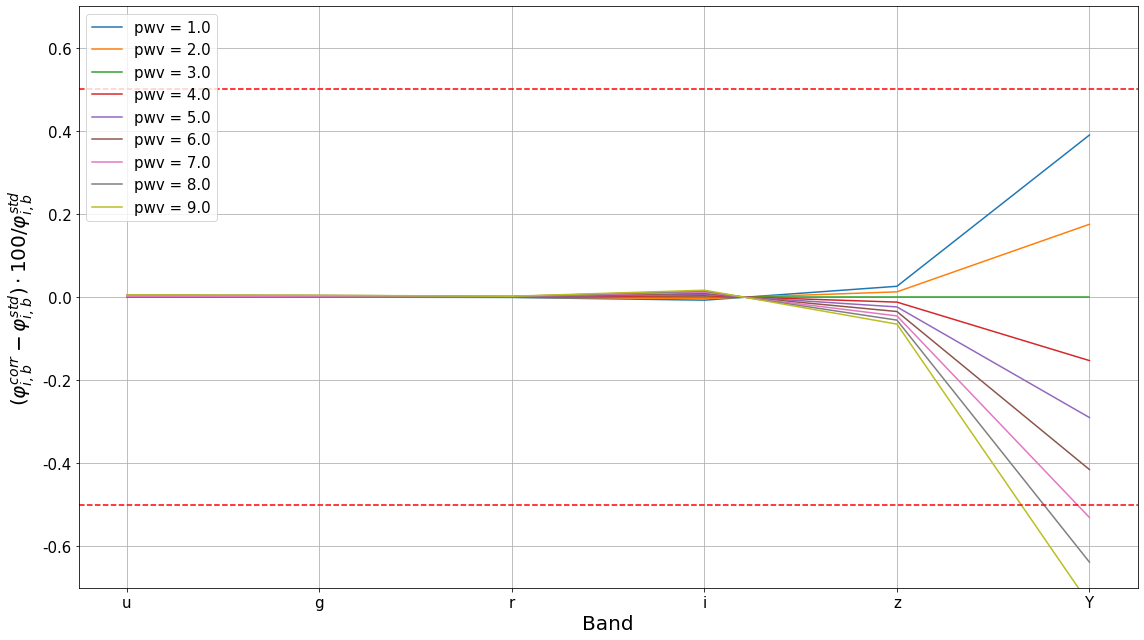

In [127]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for isim in range(n_sim):
    ax.plot(np.arange(len(filters)),(example_vec_phi_corr_dict[isim]-example_vec_phi_std)*100./example_vec_phi_std,label='{0} = {1}'.format(variable_param,atm_vals[isim]))
ax.axhline(y=-0.5,ls='--',color='r')
ax.axhline(y=0.5,ls='--',color='r')
ax.set_ylim(-0.7,0.7)
ax.grid()
ax.set_xlabel('Band',fontsize=20)
xticks = ax.get_xticks()
yticks = np.round(ax.get_yticks(),3)
ax.set_xticks(ticks=xticks[1:-1])
ax.set_xticklabels(labels=filters,fontsize=15)
ax.set_yticklabels(labels=yticks,fontsize=15)
ax.set_ylabel(r'$(\varphi_{i,b}^{corr}-\varphi_{i,b}^{std}) \cdot 100 / \varphi_{i,b}^{std}$',fontsize=20)
ax.legend(loc="best",fontsize=15)
plt.tight_layout()

### We now work with magnitudes 

If we express the correction in magnitudes, we have 

$$\vec{m}^{\, corr}_i = \vec{m}_i(t)+\vec{\mathbb{m}}^{std}_i - \vec{\mathbb{m}}_i(t) $$

In [128]:
mag_corr_dict = {}

for ised in sed_dict.keys():
    mag_corr_dict[ised] = {}
    for filter in filters:
        mag_corr_dict[ised][filter] = []
        for isim in range(n_sim):
            mag_corr_ = mag_t_dict[ised][filter][isim]+Mag_std_dict[ised][filter][isim]-Mag_t_dict[ised][filter][isim]
            mag_corr_dict[ised][filter].append(mag_corr_)
        

In [129]:
example_vec_mag_std = []
example_vec_mag_corr_dict = {}

for filter in filters:
    mag_std_ = mag_std_dict[example_id][filter]
    example_vec_mag_std.append(mag_std_)
example_vec_mag_std = np.array(example_vec_mag_std)

for isim in range(n_sim):
    example_vec_mag_corr_dict[isim] = []
    for filter in filters:
        mag_corr_ = mag_corr_dict[example_id][filter][isim]
        example_vec_mag_corr_dict[isim].append(mag_corr_)
    example_vec_mag_corr_dict[isim] = np.array(example_vec_mag_corr_dict[isim])
    

In [130]:
example_vec_mag_std

array([1.270049  , 0.15899653, 0.27684806, 0.41916318, 0.52933551,
       0.67798964])

In [131]:
example_vec_mag_corr_dict[n_sim-1]

array([1.26999125, 0.15894916, 0.27682494, 0.41898293, 0.53004234,
       0.68604442])

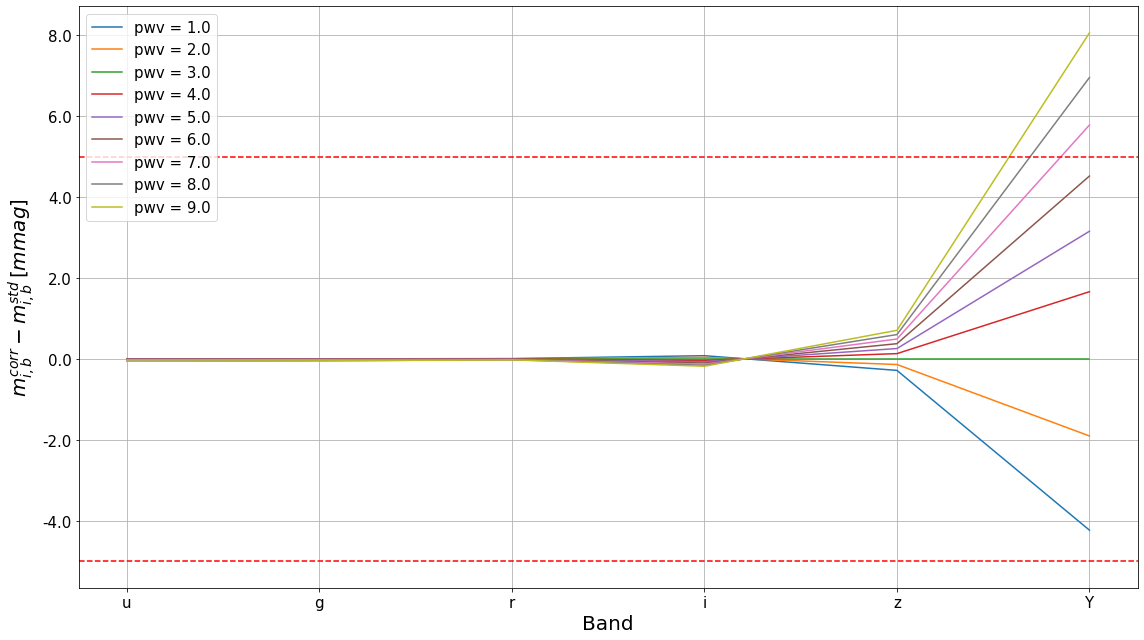

In [132]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for isim in range(n_sim):
    ax.plot(np.arange(len(filters)),(example_vec_mag_corr_dict[isim]-example_vec_mag_std)*1000.,label='{0} = {1}'.format(variable_param,atm_vals[isim]))
ax.axhline(y=5.0,ls='--',color='r')
ax.axhline(y=-5.0,ls='--',color='r')
ax.grid()
ax.set_xlabel('Band',fontsize=20)
xticks = ax.get_xticks()
yticks = np.round(ax.get_yticks(),3)
ax.set_xticks(ticks=xticks[1:-1])
ax.set_xticklabels(labels=filters,fontsize=15)
ax.set_yticklabels(labels=yticks,fontsize=15)
ax.set_ylabel(r'$m_{i,b}^{corr}-m_{i,b}^{std} \, [mmag]$',fontsize=20)
ax.legend(loc="best",fontsize=15)
plt.tight_layout()

### Impact of different atmospheres with respect to standard one 

In [133]:
Mag_diff_dict = {}

for ised in sed_dict.keys():
    Mag_diff_dict[ised] = {}
    for filter in filters:
        Mag_diff_dict[ised][filter] = []
        for isim in range(n_sim):
            Mag_diff_ = Mag_std_dict[ised][filter][isim]-Mag_t_dict[ised][filter][isim]
            Mag_diff_dict[ised][filter].append(Mag_diff_)

In [134]:
example_vec_Mag_diff_dict = {}

for isim in range(n_sim):
    example_vec_Mag_diff_dict[isim] = []
    for filter in filters:
        Mag_diff_ = Mag_diff_dict[example_id][filter][isim]
        example_vec_Mag_diff_dict[isim].append(Mag_diff_)
    example_vec_Mag_diff_dict[isim] = np.array(example_vec_Mag_diff_dict[isim])
    

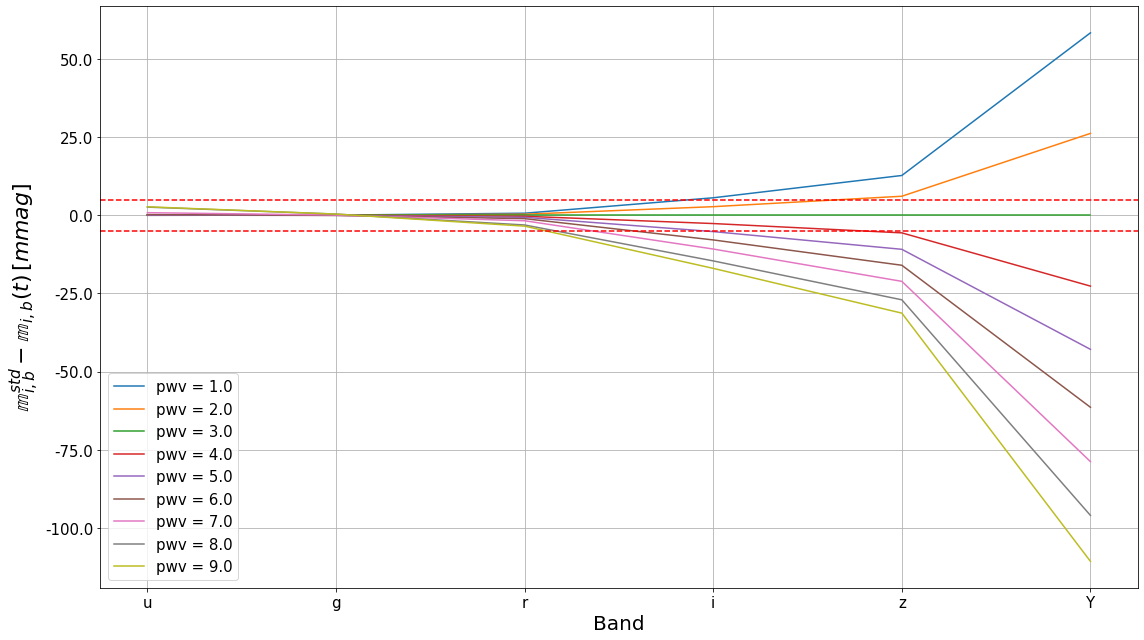

In [135]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for isim in range(n_sim):
    ax.plot(np.arange(len(filters)),example_vec_Mag_diff_dict[isim]*1000.,label='{0} = {1}'.format(variable_param,atm_vals[isim]))
ax.axhline(y=5.0,ls='--',color='r')
ax.axhline(y=-5.0,ls='--',color='r')
ax.grid()
ax.set_xlabel('Band',fontsize=20)
xticks = ax.get_xticks()
yticks = np.round(ax.get_yticks(),3)
ax.set_xticks(ticks=xticks[1:-1])
ax.set_xticklabels(labels=filters,fontsize=15)
ax.set_yticklabels(labels=yticks,fontsize=15)
ax.set_ylabel(r'$\mathbb{m}_{i,b}^{std}-\mathbb{m}_{i,b}(t) \, [mmag]$',fontsize=22)
ax.legend(loc="best",fontsize=15)
plt.tight_layout()

In [136]:
delta_mag_dict = {}

for ised in sed_dict.keys():
    delta_mag_dict[ised] = {}
    for filter in filters:
        delta_mag_dict[ised][filter] = []
        for isim in range(n_sim):
            delta_mag_ = mag_corr_dict[ised][filter][isim]-mag_std_dict[ised][filter]
            delta_mag_dict[ised][filter].append(delta_mag_)

In [137]:
delta_mag_dict

{'pickles_uk_1': {'u': [-9.805537171114764e-08,
   -5.2527345917319224e-08,
   0.0,
   6.346553499403385e-08,
   1.4447977103593246e-07,
   9.028952401290979e-07,
   3.590551425791677e-06,
   1.1311433900262902e-05,
   1.1769157759772275e-05],
  'g': [6.55553972814249e-07,
   3.3169572782876244e-07,
   -6.938893903907228e-18,
   -3.42118565116456e-07,
   -7.00930057551119e-07,
   -1.6723370259499881e-06,
   -4.385260522349332e-06,
   -1.1647487456432903e-05,
   -1.2352462767650785e-05],
  'r': [6.041844171911226e-06,
   3.0153495707008204e-06,
   0.0,
   -3.003336042028959e-06,
   -5.993885950905664e-06,
   -8.716706023204068e-06,
   -1.1075438336560772e-05,
   -1.2225198823268002e-05,
   -1.5079455965683053e-05],
  'i': [-1.2647060766868279e-05,
   -6.827247421070659e-06,
   0.0,
   7.686692931052619e-06,
   1.610569608045953e-05,
   2.5130275836171556e-05,
   3.462503073370371e-05,
   4.420849559982898e-05,
   5.462286350577106e-05],
  'z': [-0.00012093514080369072,
   -5.93827866921

In [138]:
id_by_type

{'O': ['pickles_uk_1', 'pickles_uk_2', 'pickles_uk_60'],
 'B': ['pickles_uk_3',
  'pickles_uk_4',
  'pickles_uk_5',
  'pickles_uk_6',
  'pickles_uk_7',
  'pickles_uk_8',
  'pickles_uk_46',
  'pickles_uk_47',
  'pickles_uk_61',
  'pickles_uk_62',
  'pickles_uk_63',
  'pickles_uk_64',
  'pickles_uk_106',
  'pickles_uk_107',
  'pickles_uk_114',
  'pickles_uk_115',
  'pickles_uk_116',
  'pickles_uk_117',
  'pickles_uk_118'],
 'A': ['pickles_uk_9',
  'pickles_uk_10',
  'pickles_uk_11',
  'pickles_uk_12',
  'pickles_uk_13',
  'pickles_uk_48',
  'pickles_uk_49',
  'pickles_uk_65',
  'pickles_uk_66',
  'pickles_uk_67',
  'pickles_uk_68',
  'pickles_uk_119',
  'pickles_uk_120'],
 'F': ['pickles_uk_14',
  'pickles_uk_15',
  'pickles_uk_16',
  'pickles_uk_17',
  'pickles_uk_18',
  'pickles_uk_19',
  'pickles_uk_20',
  'pickles_uk_21',
  'pickles_uk_22',
  'pickles_uk_50',
  'pickles_uk_51',
  'pickles_uk_52',
  'pickles_uk_69',
  'pickles_uk_70',
  'pickles_uk_71',
  'pickles_uk_108',
  'pickles_

In [139]:
delta_mag_dict[example_id]

{'u': [3.572819702313268e-07,
  1.9638225756679617e-07,
  -2.220446049250313e-16,
  -2.276809991652584e-07,
  -5.227962047715806e-07,
  -4.211839254253391e-06,
  -1.755005008563515e-05,
  -5.550115122066046e-05,
  -5.775774983107773e-05],
 'g': [1.6706502078134289e-06,
  8.501689781614807e-07,
  0.0,
  -8.916225780752907e-07,
  -1.8485257386735565e-06,
  -5.309922103569065e-06,
  -1.5881977099230227e-05,
  -4.502391031502295e-05,
  -4.7373998056071676e-05],
 'r': [8.575823968459684e-06,
  4.2779455690644674e-06,
  0.0,
  -4.258313009042336e-06,
  -8.496084106579538e-06,
  -1.251748615321846e-05,
  -1.6245704393014204e-05,
  -1.9027806982263584e-05,
  -2.3119994129849886e-05],
 'i': [8.011766445714663e-05,
  3.840910000535436e-05,
  -5.551115123125783e-17,
  -3.549912076361572e-05,
  -6.842567799869581e-05,
  -9.909112567874079e-05,
  -0.00012779187869638164,
  -0.00015504950738343126,
  -0.00018024206796202202],
 'z': [-0.00028269779925749194,
  -0.00013730477742157632,
  0.0,
  0.0001

In [140]:
type_colors

{'O': 'b',
 'B': 'dodgerblue',
 'A': 'cyan',
 'F': 'g',
 'G': 'gold',
 'K': 'r',
 'M': 'brown'}

u
g
r
i
z
Y


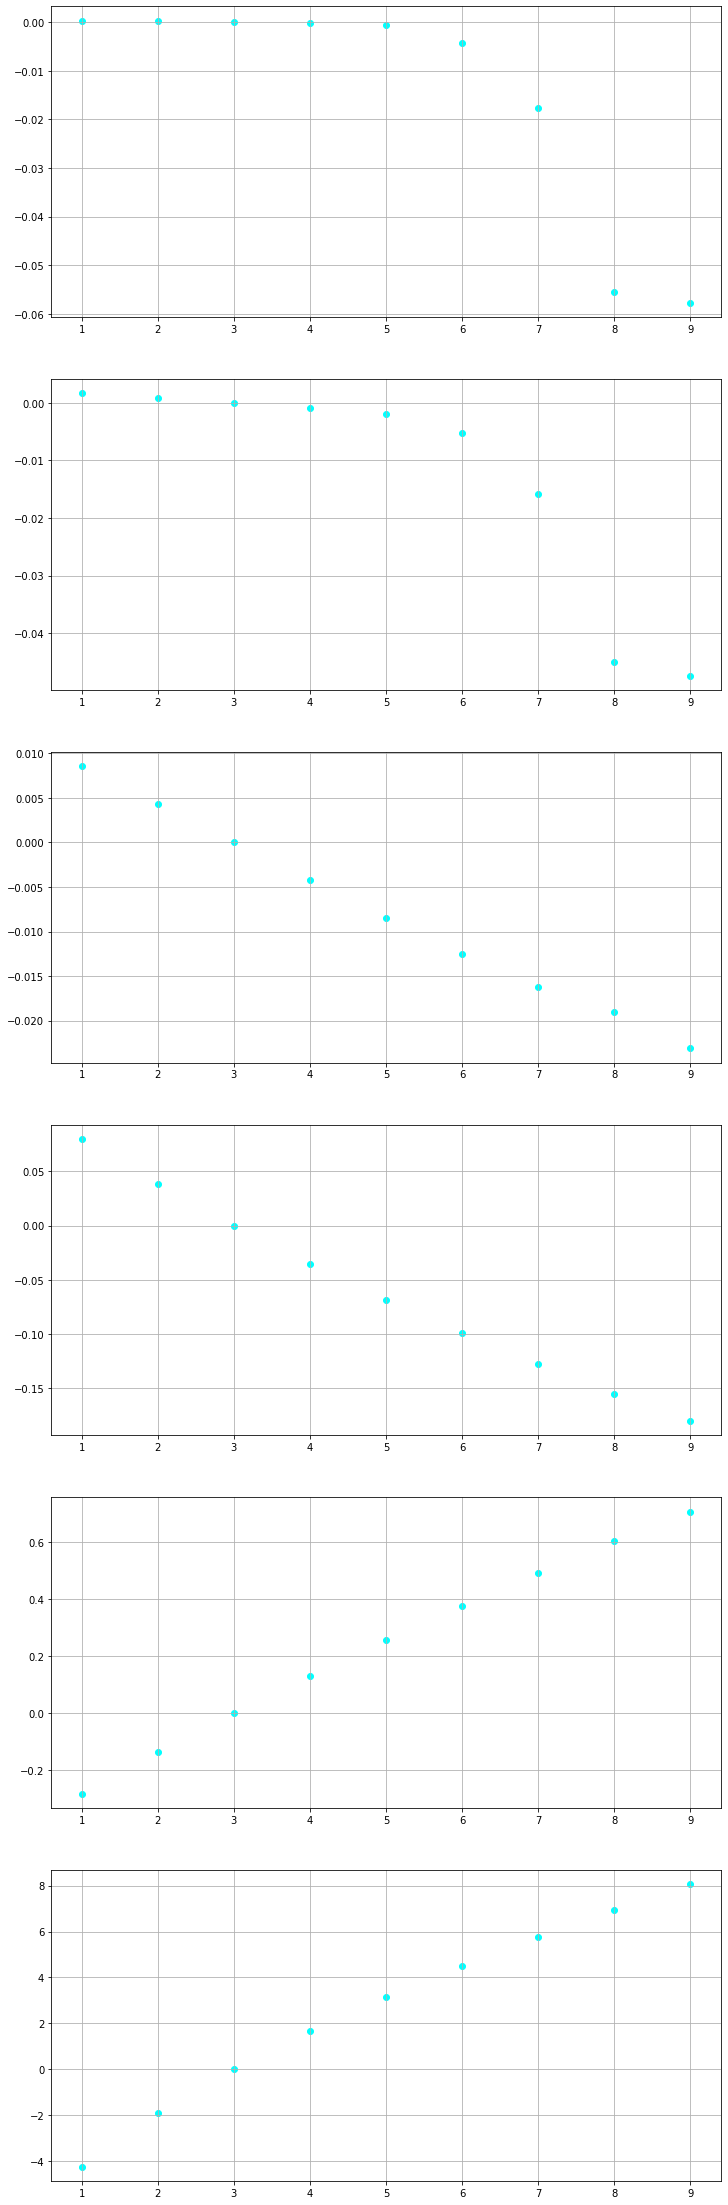

In [141]:
fig = plt.figure(figsize=(12,40))

for i,filter in enumerate(filters):
    print(filter)
    pos_ = int('{0}1{1}'.format(len(filters),i+1))
    ax = fig.add_subplot(pos_)
    
    for isim in range(n_sim):
        for type_ in spectral_types:
            
            ids_ = id_by_type[type_]
            for id_ in ids_:
                delta_mag_ = delta_mag_dict[id_][filter][isim]*1000.
                
                if id_==example_id:
                    alpha = 1.0
                    marker = 'o'
                    
                    ax.scatter(atm_vals[isim],delta_mag_,marker=marker,color=type_colors[type_],alpha=alpha)
                    ax.grid()
                


u
g
r
i
z
Y


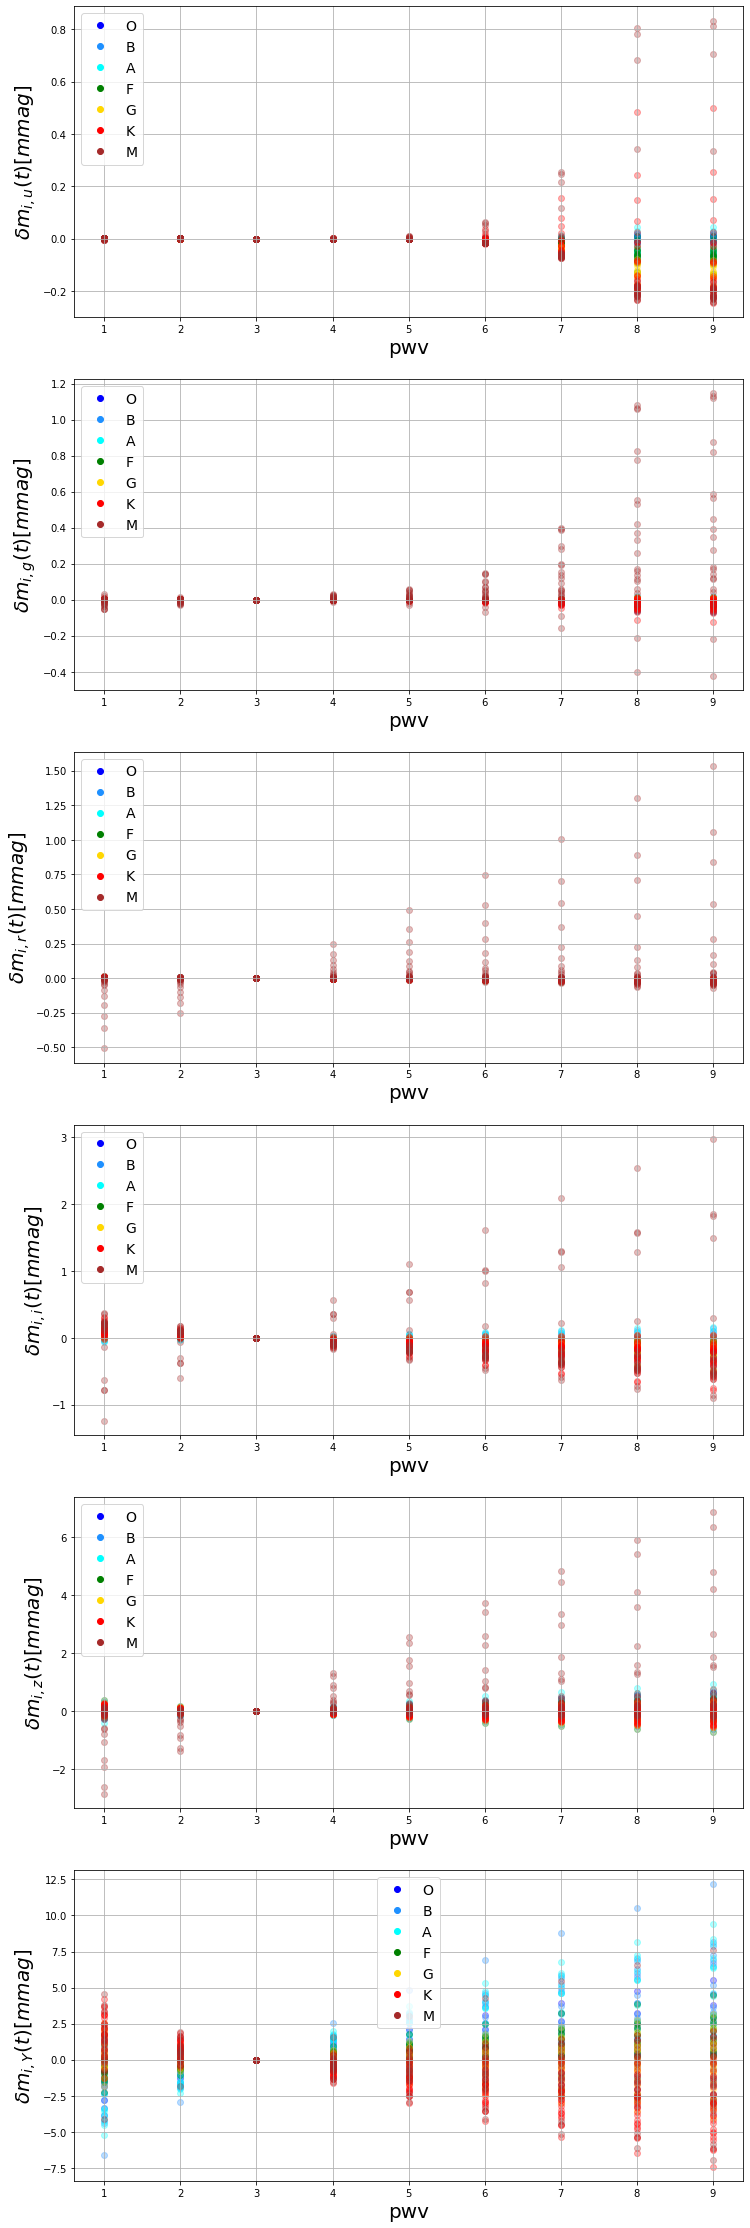

In [142]:
fig = plt.figure(figsize=(12,40))

for i,filter in enumerate(filters):
    print(filter)
    pos_ = int('{0}1{1}'.format(len(filters),i+1))
    ax = fig.add_subplot(pos_)
    
    for isim in range(n_sim):
        for type_ in spectral_types:
            
            ids_ = id_by_type[type_]
            for id_ in ids_:
                delta_mag_ = delta_mag_dict[id_][filter][isim]*1000.

                ax.scatter(atm_vals[isim],delta_mag_,marker='o',color=type_colors[type_],alpha=0.3)
                ax.grid()
                ax.set_xlabel(variable_param,fontsize=20)
                ax.set_ylabel(r'$\delta '+r'm_{i,'+r'{0}'.format(filter)+r'}(t) [mmag]$',fontsize=20)
    
    for type_ in spectral_types:
        ax.plot([],[],ls='',marker='o',color=type_colors[type_],label=type_)
        
    ax.legend(loc="best",fontsize=14)


In [143]:
poly_dict['pickles_uk_1']['std'].fluxunits

In [144]:
poly_spec_std_dict['pickles_uk_1']

array([4803.6153153 , 4800.22624548, 4796.83985532, ...,  344.68857534,
        344.94332346,  345.19834127])

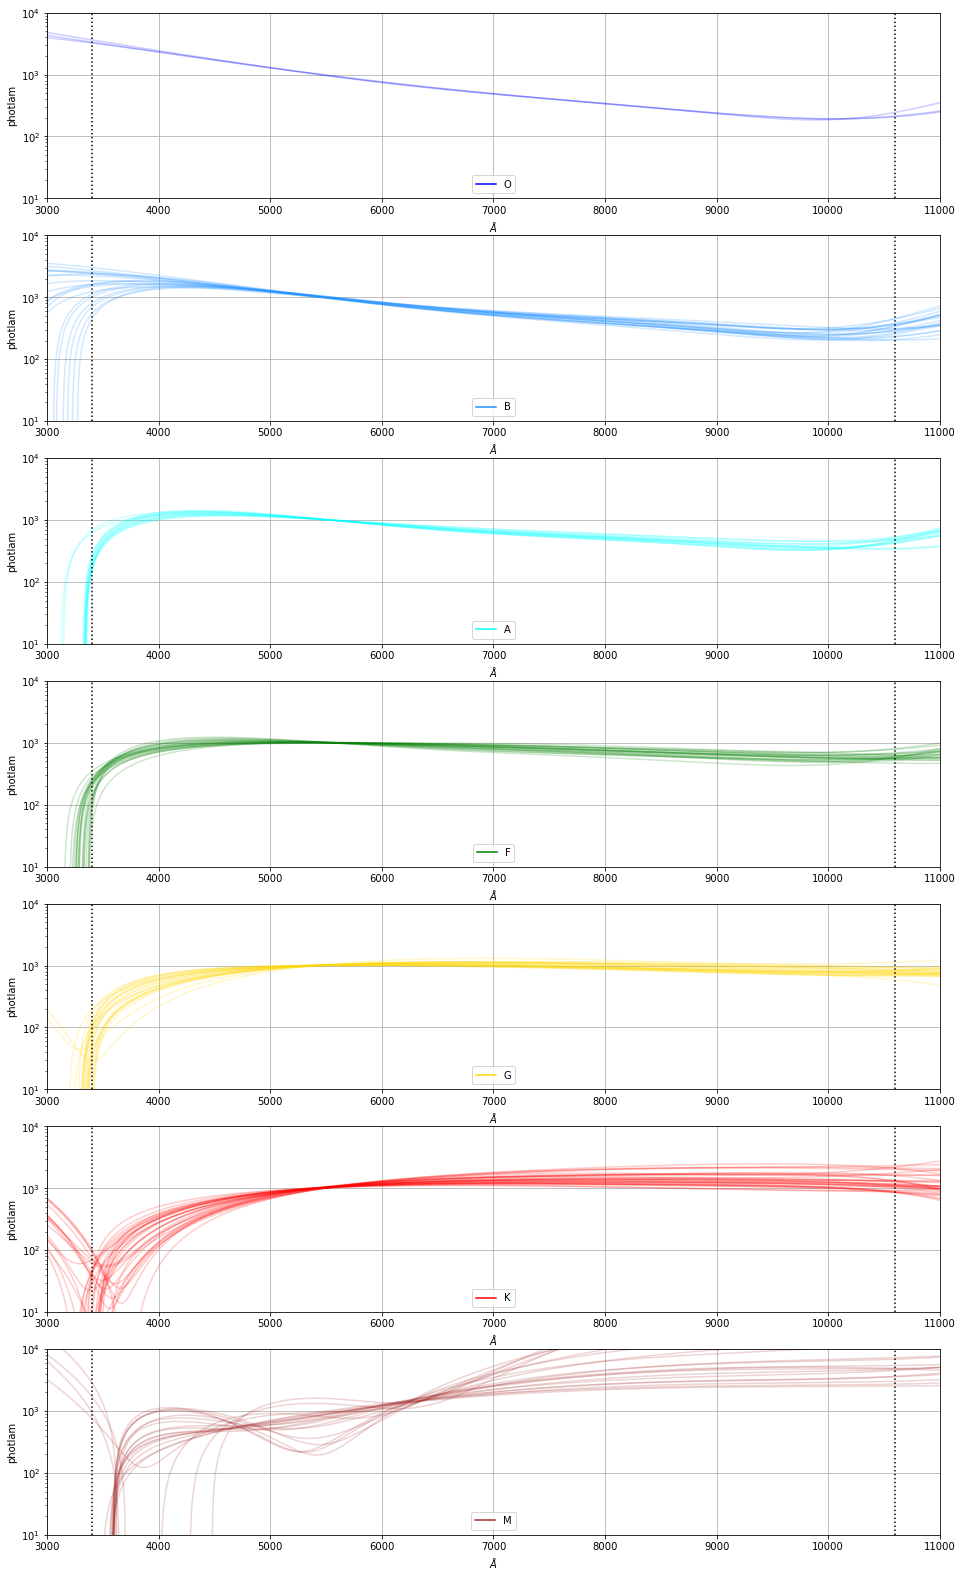

In [145]:
num_rows = len(spectral_types)
fig, axs = plt.subplots(num_rows, 1, figsize=(16,28))

for row,st in enumerate(spectral_types):
    ids_ = id_by_type[st]
    for id_ in ids_:
        spec = poly_dict[id_]['std']
        spec.convert('photlam')
        axs[row].plot(spec.wave,spec.flux,color=type_colors[st],alpha=0.2)
    axs[row].plot([],[],label=st,color=type_colors[st])
    axs[row].axvline(x=WLMIN,ls=':',color='k')
    axs[row].axvline(x=WLMAX,ls=':',color='k')
    axs[row].grid()
    #axs[row].set_yscale("log")
    axs[row].set_xlabel(wavelabel)
    axs[row].set_ylabel(spec.fluxunits)
    axs[row].legend()
    axs[row].set_xlim(3000,11000)
    axs[row].set_ylim(10,10000)
    axs[row].set_yscale("log")
            

In [146]:
atm_val_ref = 5.
ref_index = np.where(atm_vals==atm_val_ref)[0][0]
ref_index

4

In [147]:
test_type_ = 'M'
test_band_ = 'i'
ids_ = id_by_type[test_type_]
print(len(ids_))

21


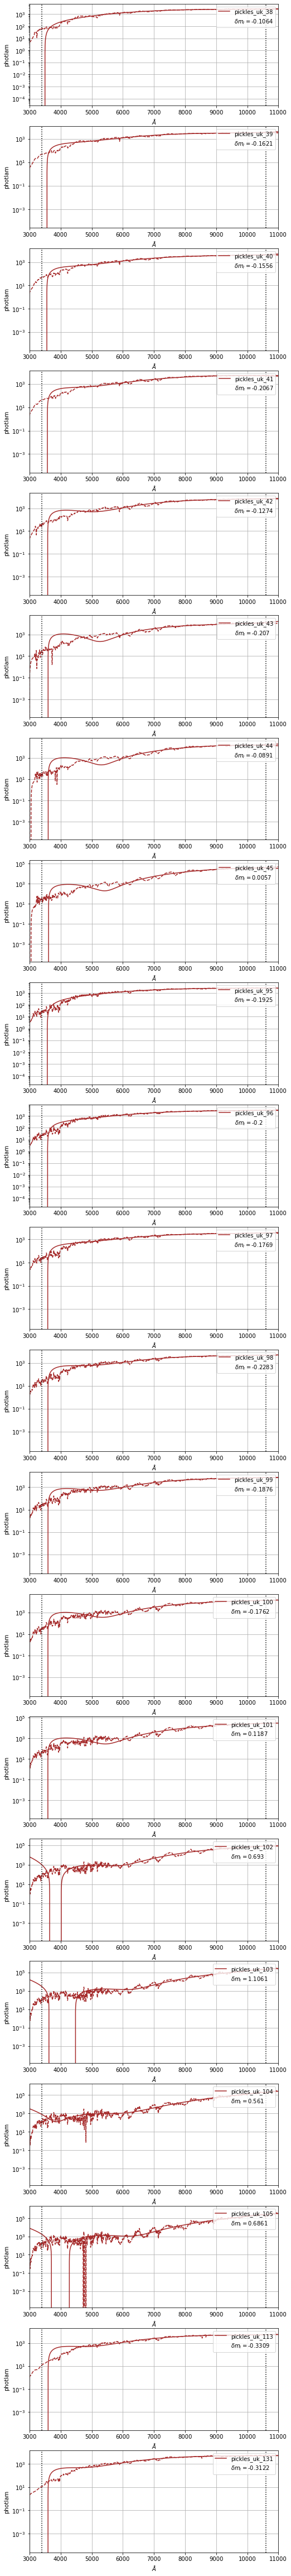

In [148]:

fig,axs = plt.subplots(len(ids_),figsize=(8,len(ids_)*4))

for i,id_ in enumerate(ids_):
    
    poly_spec_ = poly_dict[id_]['std']
    spec_ = spec_by_type[test_type_][i]
    spec.convert('photlam')
    axs[i].plot(spec_.wave,spec_.flux,ls='--',color=type_colors[test_type_],alpha=1.0)
    axs[i].plot(poly_spec_.wave,poly_spec_.flux,ls='-',color=type_colors[test_type_],alpha=1.0,label=id_)
    axs[i].plot([],[],ls='',marker='',label=r'$\delta m_{i} = $'+str(np.round(delta_mag_dict[id_][test_band_][ref_index]*1000.,4)))
    axs[i].axvline(x=WLMIN,ls=':',color='k')
    axs[i].axvline(x=WLMAX,ls=':',color='k')
    axs[i].set_xlim(3000,11000)
    #axs[i].set_ylim(10,10000)
    axs[i].set_yscale("log")
    axs[i].grid()
    axs[i].set_xlabel(wavelabel)
    axs[i].set_ylabel(spec.fluxunits)
    axs[i].legend(loc="upper right")
    


In [149]:
obs_poly_std_dict

{'pickles_uk_1': {'u': <pysynphot.observation.Observation at 0x7ff0fe2f87c0>,
  'g': <pysynphot.observation.Observation at 0x7ff0fe2f87f0>,
  'r': <pysynphot.observation.Observation at 0x7ff0fe2f6700>,
  'i': <pysynphot.observation.Observation at 0x7ff0fefa91f0>,
  'z': <pysynphot.observation.Observation at 0x7ff0fedb0cd0>,
  'Y': <pysynphot.observation.Observation at 0x7ff0fedb69d0>},
 'pickles_uk_2': {'u': <pysynphot.observation.Observation at 0x7ff0fed40c40>,
  'g': <pysynphot.observation.Observation at 0x7ff0fedb6160>,
  'r': <pysynphot.observation.Observation at 0x7ff0feceba00>,
  'i': <pysynphot.observation.Observation at 0x7ff0fedb05b0>,
  'z': <pysynphot.observation.Observation at 0x7ff0fecf55b0>,
  'Y': <pysynphot.observation.Observation at 0x7ff0fef4a490>},
 'pickles_uk_3': {'u': <pysynphot.observation.Observation at 0x7ff0fe79c4f0>,
  'g': <pysynphot.observation.Observation at 0x7ff0fe7a3c40>,
  'r': <pysynphot.observation.Observation at 0x7ff0fe7a9a90>,
  'i': <pysynphot.ob

In [150]:
phi_corr_dict

{'pickles_uk_1': {'u': [3662442861058.361,
   3662442707481.6553,
   3662442530294.61,
   3662442316210.5015,
   3662442042930.533,
   3662439484618.746,
   3662430418543.6636,
   3662404374377.35,
   3662402830383.969],
  'g': [8682517437563.693,
   8682520027424.164,
   8682522679960.965,
   8682525415848.979,
   8682528285229.592,
   8682536053481.415,
   8682557748516.908,
   8682615824240.401,
   8682621461919.016],
  'r': [4277287089497.9287,
   4277299012471.7324,
   4277310891572.3774,
   4277322723377.9995,
   4277334504844.475,
   4277345231600.0146,
   4277354524026.0464,
   4277359053612.332,
   4277370298239.3633],
  'i': [2311647097495.228,
   2311634706530.91,
   2311620170723.4097,
   2311603805190.557,
   2311585880648.5034,
   2311566666953.36,
   2311546452408.731,
   2311526049177.8647,
   2311503877155.655],
  'z': [1237222630939.655,
   1237152492533.5225,
   1237084830100.2007,
   1237019680025.2512,
   1236956993333.1042,
   1236896679132.1543,
   1236838591360.

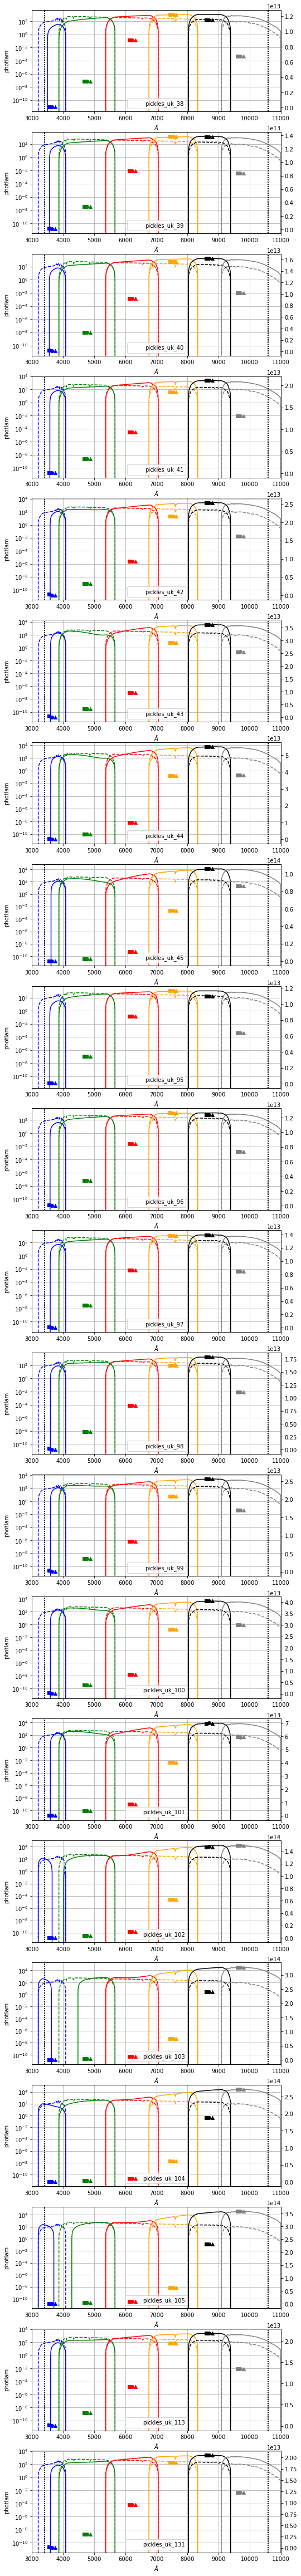

In [151]:

fig,axs = plt.subplots(len(ids_),figsize=(8,len(ids_)*4))

for i,id_ in enumerate(ids_):
    axs[i].grid()
    axs2 = axs[i].twinx()
    for j,filter in enumerate(filters):
        
        poly_spec_ = obs_poly_std_dict[id_][filter]
        spec_ = obs_flux_std_dict[id_][filter]
        spec.convert('photlam')
        axs[i].plot(spec_.wave,spec_.flux,ls='--',color=filter_colors[j],alpha=1.0)
        axs[i].plot(poly_spec_.wave,poly_spec_.flux,ls='-',color=filter_colors[j],alpha=1.0)
        axs[i].axvline(x=WLMIN,ls=':',color='k')
        axs[i].axvline(x=WLMAX,ls=':',color='k')
        axs[i].set_xlim(3000,11000)
        #axs[i].set_ylim(10,10000)
        axs[i].set_yscale("log")
        axs[i].set_xlabel(wavelabel)
        axs[i].set_ylabel(spec.fluxunits)
        
        axs2.scatter(eff_lambda[filter],phi_std_dict[id_][filter],marker='o',color=filter_colors[j])
        axs2.scatter(eff_lambda[filter]-100.,Phi_std_dict[id_][filter][ref_index],marker='s',color=filter_colors[j])
        axs2.scatter(eff_lambda[filter]+100.,phi_corr_dict[id_][filter][ref_index],marker='^',color=filter_colors[j])
        
    axs[i].plot([],[],ls='',marker='',label=id_)
    axs[i].legend(loc="best")
    
    


In [152]:
problem_spec = [45,101,102,103,104,105]
problem_ids = ['pickles_uk_{0}'.format(i) for i in problem_spec]
problem_ids

['pickles_uk_45',
 'pickles_uk_101',
 'pickles_uk_102',
 'pickles_uk_103',
 'pickles_uk_104',
 'pickles_uk_105']

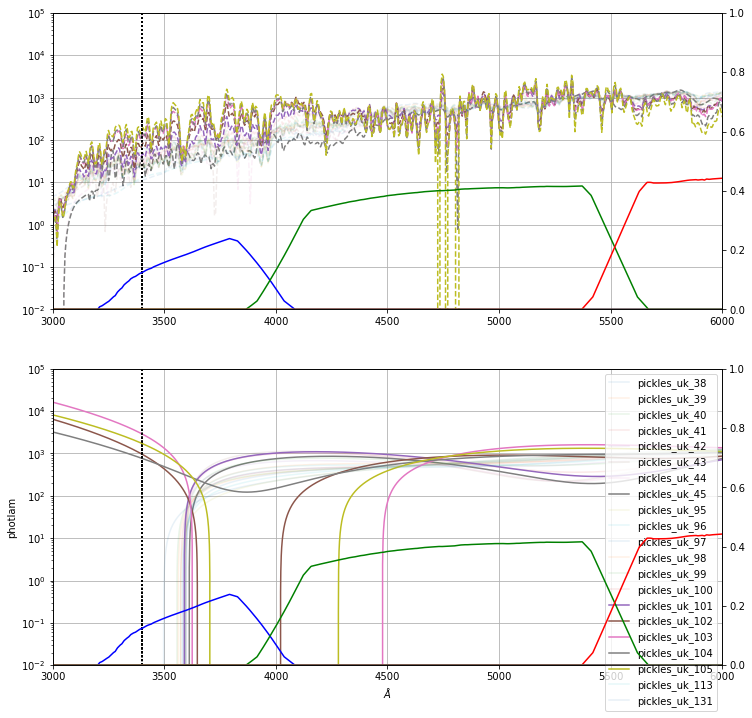

In [153]:

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax3 = ax1.twinx()
ax4 = ax2.twinx()

for i,id_ in enumerate(ids_):
    
    if id_ in problem_ids:
        alpha = 1.0
    else:
        alpha = 0.1
    poly_spec_ = poly_dict[id_]['std']
    spec_ = spec_by_type[test_type_][i]
    spec.convert('photlam')
    ax1.plot(spec_.wave,spec_.flux,ls='--',alpha=alpha)
    ax1.axvline(x=WLMIN,ls=':',color='k')
    ax1.axvline(x=WLMAX,ls=':',color='k')
    #ax1.set_xlim(3000,11000)
    ax1.set_xlim(3000,6000)
    ax1.set_ylim(1e-2,1e5)
    ax1.set_yscale("log")
    ax1.grid()
    ax2.set_xlabel(wavelabel)
    ax2.set_ylabel(spec.fluxunits)
    
    ax2.plot(poly_spec_.wave,poly_spec_.flux,ls='-',alpha=alpha,label=id_)
    ax2.axvline(x=WLMIN,ls=':',color='k')
    ax2.axvline(x=WLMAX,ls=':',color='k')
    #ax2.set_xlim(3000,11000)
    ax2.set_xlim(3000,6000)
    ax2.set_ylim(1e-2,1e5)
    ax2.set_yscale("log")
    ax2.grid()
    ax2.set_xlabel(wavelabel)
    ax2.set_ylabel(poly_spec_.fluxunits)
    ax2.legend(loc="upper right")
    
    
for i,filter in enumerate(filters):
    ax3.plot(total_passband_ref[filter].wave,total_passband_ref[filter].throughput,ls='-',color=filter_colors[i])
    ax3.set_ylim(0.,1.0)
    ax4.plot(total_passband_ref[filter].wave,total_passband_ref[filter].throughput,ls='-',color=filter_colors[i])
    ax4.set_ylim(0.,1.0)
    

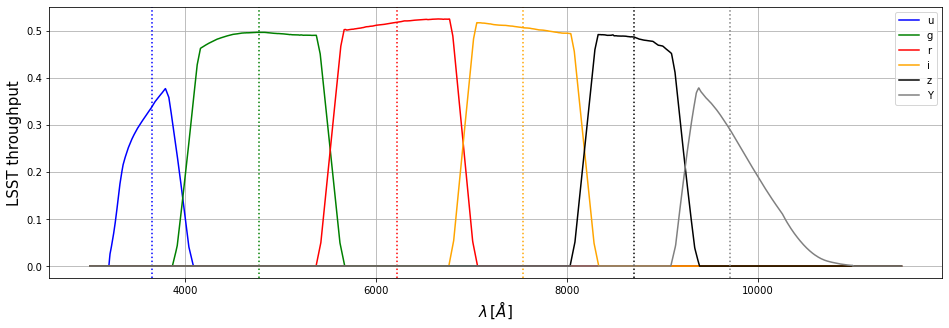

In [154]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for i,filter in enumerate(filters):
    ax.plot(lsst_bp[i].wave,lsst_bp[i].throughput,label=filter_names[i],color=filter_colors[i])
    ax.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('LSST throughput',fontsize=15)
ax.legend()

No handles with labels found to put in legend.


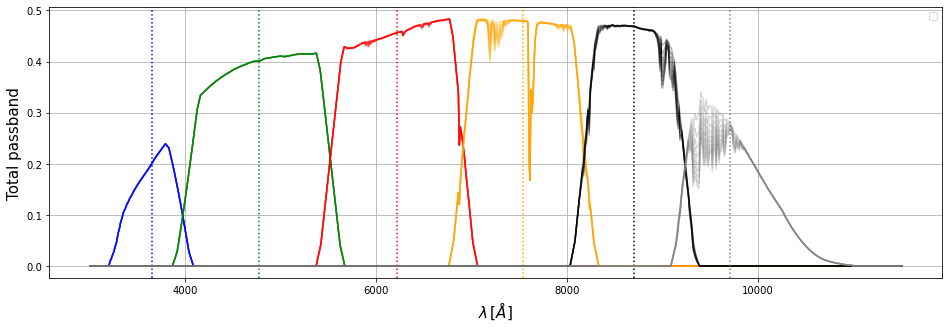

In [155]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for i,filter in enumerate(filters):
    for isim in range(n_sim):
        ax.plot(total_passband[filter][isim].wave,total_passband[filter][isim].throughput,color=filter_colors[i],alpha=0.3)
    ax.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('Total passband',fontsize=15)
ax.legend()

In [156]:
from scipy.interpolate import InterpolatedUnivariateSpline

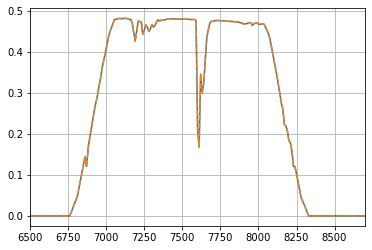

In [157]:
pwave = total_passband['i'][4].wave
passb = total_passband['i'][4].throughput
p_interp = interp1d(pwave,passb,bounds_error=False,fill_value=0.)
pinterp = p_interp(pwave)
plt.plot(pwave,passb)
plt.plot(pwave,pinterp,ls='--')
plt.xlim(6500,8700)
plt.grid()

In [158]:
np.max(passb)*0.65

0.31349643682052175

In [159]:
spl.integral(7400.,7401.)

NameError: name 'spl' is not defined

In [ ]:
pwave = total_passband['i'][4].wave
passb = total_passband['i'][4].throughput
p_interp = interp1d(pwave,passb-np.max(passb)*0.65,bounds_error=False,fill_value=0.)
pinterp = p_interp(pwave)
plt.plot(pwave,passb)
plt.plot(pwave,pinterp,ls='--')
plt.xlim(6500,8700)
plt.grid()

In [ ]:
spl = InterpolatedUnivariateSpline(pwave,passb-np.max(passb)*0.65)

In [ ]:
spl.roots()

In [ ]:
pwave = total_passband['i'][4].wave
passb = total_passband['i'][4].throughput
p_interp = interp1d(pwave,passb,bounds_error=False,fill_value=0.)
pinterp = p_interp(pwave)
plt.plot(pwave,passb)
plt.plot(pwave,pinterp,ls='--')
x_ = np.linspace(spl.roots()[0],spl.roots()[-1],100)
plt.plot(x_,np.ones(len(x_))*np.max(passb)*0.65)
plt.xlim(6500,8700)
plt.grid()

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for i,filter in enumerate(filters):
    for isim in range(n_sim):
        wave_ = total_passband[filter][isim].wave
        through_ = total_passband[filter][isim].throughput
        ax.plot(wave_,through_,color=filter_colors[i],alpha=0.3)
        int_passb_ = np.trapz(through_,x=wave_)
        spl_ = InterpolatedUnivariateSpline(wave_,through_-np.max(through_)*0.65)
        lambda_b_ = spl_.roots()[0]
        lambda_r_ = spl_.roots()[-1]
        delta_lambda_ = lambda_r_-lambda_b_
        x_ = np.linspace(lambda_b_,lambda_r_,100)
        ax.plot(x_,np.ones(len(x_))*int_passb_/delta_lambda_,ls='--',color=filter_colors[i],alpha=0.5)
    ax.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('Total passband',fontsize=15)
ax.legend()

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for i,filter in enumerate(filters):
    wave_ = lsst_bp[i].wave
    through_ = lsst_bp[i].throughput
    ax.plot(wave_,through_,color=filter_colors[i],alpha=1.0)
    int_passb_ = np.trapz(through_,x=wave_)
    spl_ = InterpolatedUnivariateSpline(wave_,through_-np.max(through_)*0.65)
    lambda_b_ = spl_.roots()[0]
    lambda_r_ = spl_.roots()[-1]
    delta_lambda_ = lambda_r_-lambda_b_
    print(int_passb_,delta_lambda_)
    x_ = np.linspace(lambda_b_,lambda_r_,100)
    ax.plot(x_,np.ones(len(x_))*int_passb_/delta_lambda_,ls='--',color=filter_colors[i],alpha=1.0)
    ax.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('Total passband',fontsize=15)
ax.legend()